# Gene-level Quality control

In [1]:
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio
from scipy import stats
from scipy.stats import chi2_contingency
from typing import Callable

def _resolve_project_root() -> Path:
    """locate project root containing config.py."""
    here = Path.cwd().resolve()
    for candidate in (here, *here.parents):
        if (candidate / 'config.py').exists():
            print(candidate)
            return candidate
    raise FileNotFoundError('config.py not found in cwd or parents')


PROJECT_ROOT = _resolve_project_root()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.append(str(PROJECT_ROOT))

from config import GENE_PATHS, SOURCE_PALETTE, VARIANT_PATHS

/Users/markus/in-silico-vg-analysis


In [2]:
# make plots for gene-level qc, compare genesets, 

Variance (VG) and Magnitude (∣Score∣) are the only valid ways to measure regulatory burden in these genes. You must measure the "spread," not the "average."

In [3]:
CLINGEN_VAR = VARIANT_PATHS['clingen']
BG_VAR = VARIANT_PATHS['background']
BG_NULL_VAR = VARIANT_PATHS['background_null']
CLINGEN_NULL_VAR = VARIANT_PATHS['clingen_null']

CLINGEN_GENE = GENE_PATHS['clingen']
BG_GENE = GENE_PATHS['background']
BG_NULL_GENE = GENE_PATHS['background_null']
CLINGEN_NULL_GENE = GENE_PATHS['clingen_null']

PATHS = {
    'background': BG_GENE,
    'background_null': BG_NULL_GENE,
    'clingen': CLINGEN_GENE,
    'clingen_null': CLINGEN_NULL_GENE,
}

df = pl.read_parquet(CLINGEN_GENE)
print(df.columns)

['gene_id', 'n_variants', 'vg_predicted', 'sum_sq_raw_score', 'mean_raw_score', 'mean_abs_effect', 'median_abs_effect', 'std_abs_effect', 'min_abs_effect', 'max_abs_effect', 'skewness_effect', 'q90_abs_effect', 'min_variant_id', 'min_variant_score', 'max_variant_id', 'max_variant_score', 'mean_dist_to_tss', 'median_dist_to_tss', 'min_dist_to_tss', 'max_dist_to_tss', 'n_high_impact_gt05', 'n_high_impact_gt1', 'mean_abs_promoter', 'n_variants_promoter', 'mean_abs_up2kb', 'n_variants_up2kb', 'mean_abs_up10kb', 'n_variants_up10kb', 'mean_abs_up100kb', 'n_variants_up100kb', 'mean_abs_down2kb', 'n_variants_down2kb', 'mean_abs_gene_body', 'n_variants_gene_body', 'gene_symbol', 'gene_type', 'chrom', 'genomic_length', 'exonic_length', 'coding_length', 'intronic_length', 'utr_length', 'utr5_length', 'mane_transcript_id', 'is_mane', 'tpm_muscle', 'ncRVIS', 'loeuf_score', 'ncGERP', 'RVIS_score', 'ncCADD', 'pHaplo', 'pTriplo', 'Episcore', 'pLI', 'median_tpm', 'num_enh', 'num_super_enh', 'tau', 'vg_

# Compare gene metrics

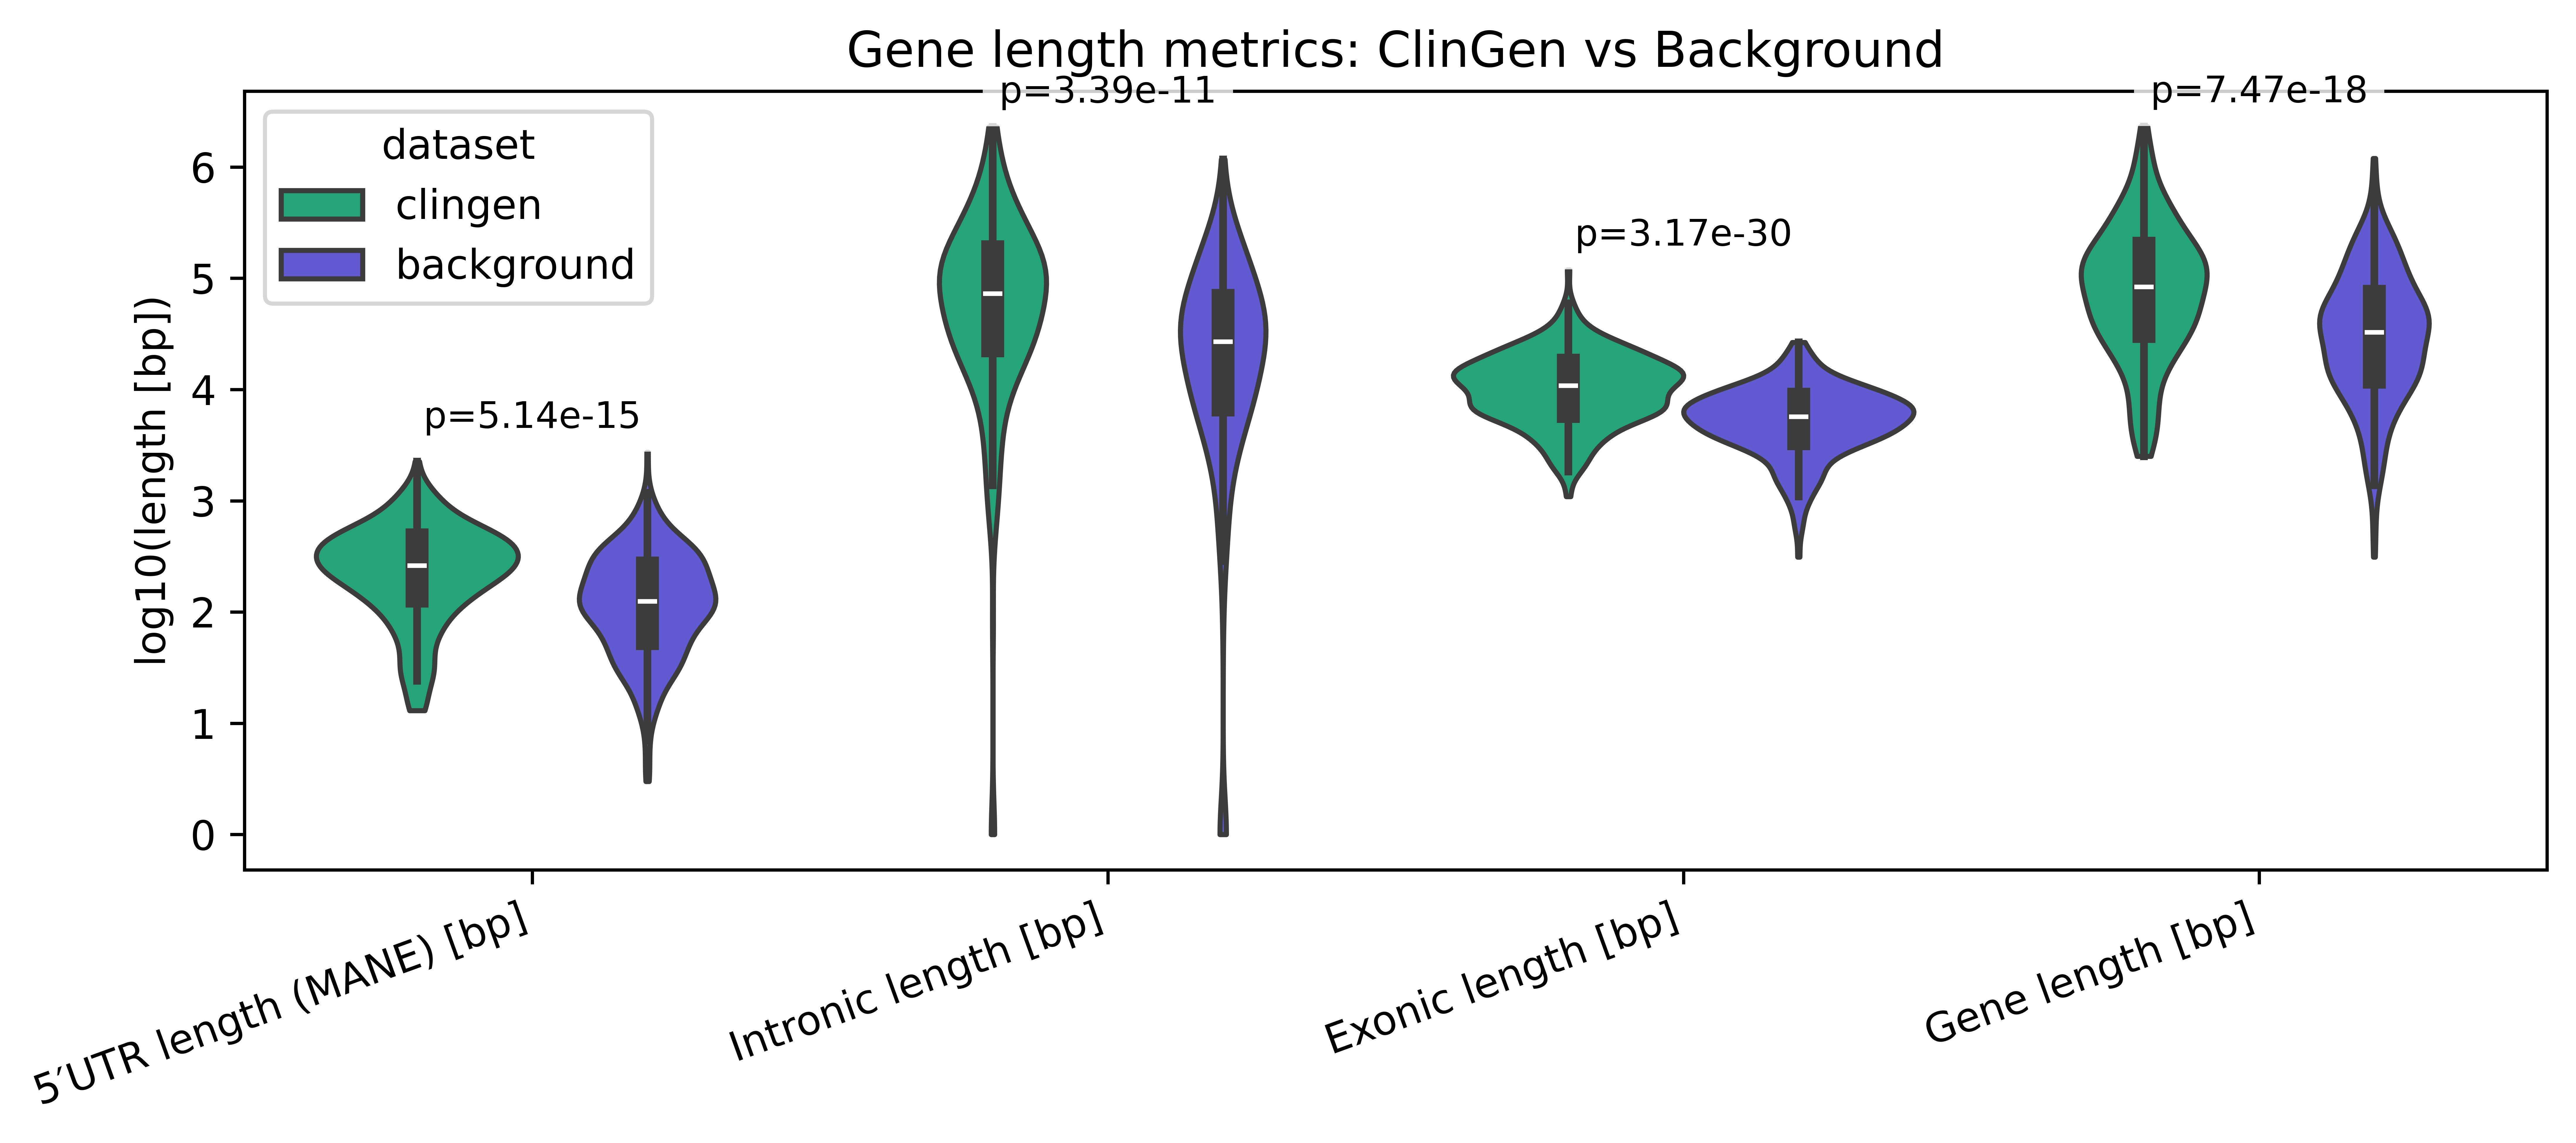

In [4]:

length_cols = {
    'utr5_length': '5′UTR length (MANE) [bp]',
    'intronic_length': 'Intronic length [bp]',
    'exonic_length': 'Exonic length [bp]',
    'genomic_length': 'Gene length [bp]',
}

def _load_length_metrics() -> pd.DataFrame:
    """collect gene length metrics for clingen and background.

    returns:
        pd.DataFrame: length metrics with dataset labels.
    """
    frames: list[pl.DataFrame] = []
    for dataset, path in {'clingen': CLINGEN_GENE, 'background': BG_GENE}.items():
        frame = pl.read_parquet(path)
        missing = [col for col in length_cols if col not in frame.columns]
        if missing:
            raise ValueError(f'missing columns {missing} in {dataset} gene file')
        subset = frame.select(list(length_cols.keys())).with_columns(
            pl.lit(dataset).alias('dataset')
        )
        frames.append(subset)
    return pl.concat(frames, how='vertical').to_pandas()

def _compute_length_p_values(length_long: pd.DataFrame) -> dict[str, float]:
    """compute welch p-values on log10 lengths per metric."""
    p_values: dict[str, float] = {}
    for metric, label in length_cols.items():
        subset = length_long[length_long['metric'] == metric]
        clingen_vals = subset.loc[subset['dataset'] == 'clingen', 'length_log10'].dropna()
        background_vals = subset.loc[subset['dataset'] == 'background', 'length_log10'].dropna()
        if clingen_vals.empty or background_vals.empty:
            raise ValueError(f'no data for {metric}')
        _, p_value = stats.ttest_ind(clingen_vals, background_vals, equal_var=False)
        p_values[label] = float(p_value)
    return p_values

combined_df = _load_length_metrics()
palette = {key: SOURCE_PALETTE[key] for key in combined_df['dataset'].unique()}

length_long = combined_df.melt(
    id_vars=['dataset'],
    value_vars=list(length_cols.keys()),
    var_name='metric',
    value_name='length_bp',
)
length_long['metric_label'] = length_long['metric'].map(length_cols)
length_long['length_log10'] = np.log10(length_long['length_bp'].clip(lower=1))

p_values = _compute_length_p_values(length_long)
order = list(length_cols.values())

plt.figure(figsize=(9, 4), dpi=1000)
ax = sns.violinplot(
    data=length_long,
    x='metric_label',
    y='length_log10',
    hue='dataset',
    dodge=True,
    cut=0,
    palette=palette,
    order=order,
)

# annotate per-metric welch p-values on log10 lengths
for idx, label in enumerate(order):
    y_max = length_long.loc[length_long['metric_label'] == label, 'length_log10'].max()
    ax.text(
        idx,
        y_max + 0.15,
        f'p={p_values[label]:.2e}',
        ha='center',
        va='bottom',
        fontsize=9,
        bbox={'facecolor': 'white', 'alpha': 0.8, 'edgecolor': 'none'},
    )

plt.ylabel('log10(length [bp])')
plt.xlabel('')
plt.xticks(rotation=20, ha='right')
plt.title('Gene length metrics: ClinGen vs Background')
plt.tight_layout()
plt.show()


## Investigate the bias

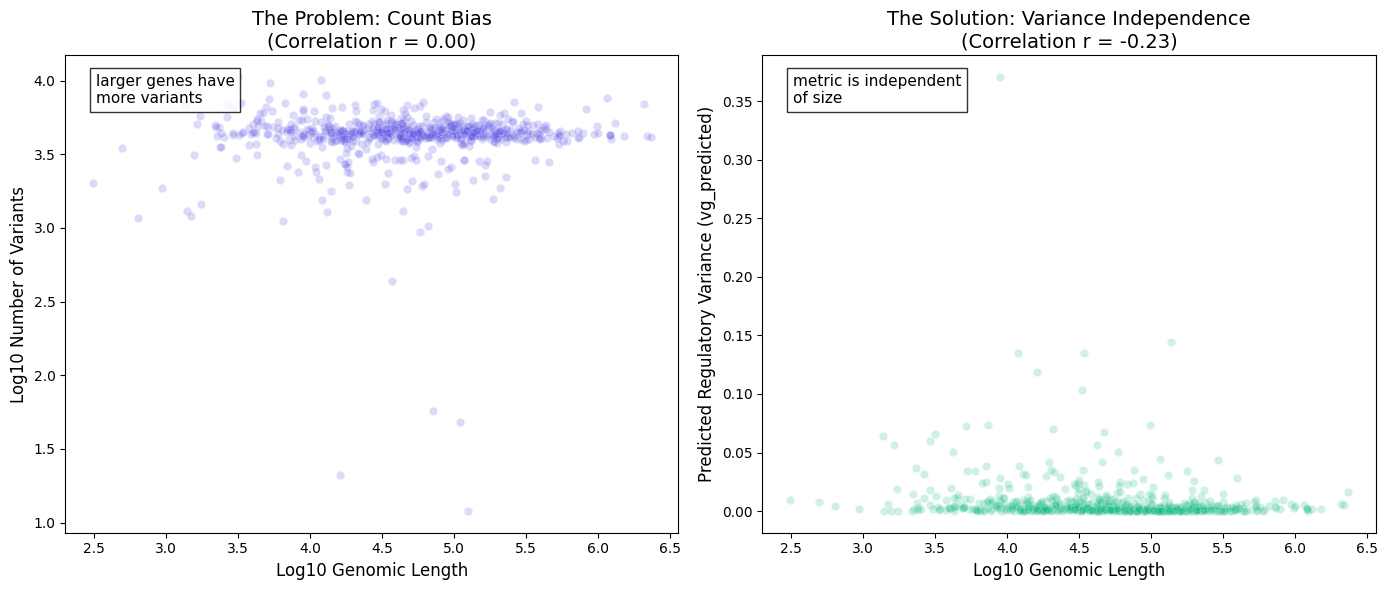

Correlation (Length vs Count):    r=0.000 (p=9.99e-01)
Correlation (Length vs Variance): r=-0.230   (p=1.86e-09)


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

def plot_length_bias_check(df: pd.DataFrame) -> None:
    """show length bias in variant counts and contrast with vg_predicted.

    args:
        df (pd.DataFrame): gene metrics with genomic_length, n_variants, vg_predicted.

    returns:
        None
    """
    df = df.copy()
    df['log_length'] = np.log10(df['genomic_length'].clip(lower=1))
    df['log_n_variants'] = np.log10(df['n_variants'].clip(lower=1))

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.scatterplot(
        data=df,
        x='log_length',
        y='log_n_variants',
        alpha=0.2,
        ax=axes[0],
        color='#4F46E5',
    )

    r_count, p_count = stats.spearmanr(df['genomic_length'], df['n_variants'])

    axes[0].set_title(
        f'The Problem: Count Bias\n(Correlation r = {r_count:.2f})', fontsize=14
    )
    axes[0].set_xlabel('Log10 Genomic Length', fontsize=12)
    axes[0].set_ylabel('Log10 Number of Variants', fontsize=12)
    axes[0].text(
        0.05,
        0.9,
        'larger genes have\nmore variants',
        transform=axes[0].transAxes,
        fontsize=11,
        bbox=dict(facecolor='white', alpha=0.8),
    )

    sns.scatterplot(
        data=df,
        x='log_length',
        y='vg_predicted',
        alpha=0.2,
        ax=axes[1],
        color='#10B981',
    )

    r_var, p_var = stats.spearmanr(df['genomic_length'], df['vg_predicted'])

    axes[1].set_title(
        f'The Solution: Variance Independence\n(Correlation r = {r_var:.2f})', fontsize=14
    )
    axes[1].set_xlabel('Log10 Genomic Length', fontsize=12)
    axes[1].set_ylabel('Predicted Regulatory Variance (vg_predicted)', fontsize=12)
    axes[1].text(
        0.05,
        0.9,
        'metric is independent\nof size',
        transform=axes[1].transAxes,
        fontsize=11,
        bbox=dict(facecolor='white', alpha=0.8),
    )

    plt.tight_layout()
    plt.show()

    print(f'Correlation (Length vs Count):    r={r_count:.3f} (p={p_count:.2e})')
    print(f'Correlation (Length vs Variance): r={r_var:.3f}   (p={p_var:.2e})')

combined_bias_df = (
    pl.concat(
        [
            pl.read_parquet(CLINGEN_GENE).with_columns(pl.lit('clingen').alias('dataset')),
            pl.read_parquet(BG_GENE).with_columns(pl.lit('background').alias('dataset')),
        ],
        how='vertical',
    )
    .select(['dataset', 'genomic_length', 'n_variants', 'vg_predicted'])
    .to_pandas()
)

plot_length_bias_check(combined_bias_df)

In [6]:
print(combined_bias_df[['genomic_length', 'n_variants', 'vg_predicted']].describe())

       genomic_length    n_variants  vg_predicted
count    6.650000e+02    665.000000  6.650000e+02
mean     1.192679e+05   4372.595489  7.720314e-03
std      2.278860e+05   1126.489126  2.065823e-02
min      3.120000e+02     12.000000  8.321866e-07
25%      1.782600e+04   4048.000000  8.604148e-04
50%      4.779000e+04   4394.000000  2.502214e-03
75%      1.251700e+05   4797.000000  6.663008e-03
max      2.304997e+06  10559.000000  3.708431e-01


In [7]:
print(combined_bias_df[['dataset', 'genomic_length', 'n_variants']].head(10))

   dataset  genomic_length  n_variants
0  clingen          984253        4877
1  clingen           29417        4388
2  clingen          184423        1571
3  clingen           44413        6328
4  clingen          785040        4391
5  clingen          495961        4184
6  clingen          101687        4128
7  clingen          118588        4577
8  clingen          103948        4650
9  clingen          136829        4616


## Correlations

In [ ]:
TARGET_METRICS = ['vg_predicted', 'sum_sq_raw_score']
PREDICTOR_METRICS = [
    'median_dist_to_tss',
    'min_dist_to_tss',
    'max_dist_to_tss',
    'n_high_impact_gt05',
    'n_high_impact_gt1',
    'mean_abs_promoter',
    'n_variants_promoter',
    'mean_abs_up2kb',
    'n_variants_up2kb',
    'mean_abs_up10kb',
    'n_variants_up10kb',
    'mean_abs_up100kb',
    'n_variants_up100kb',
    'mean_abs_down2kb',
    'n_variants_down2kb',
    'genomic_length',
    'exonic_length',
    'coding_length',
    'intronic_length',
    'utr_length',
    'utr5_length',
  #  'mane_transcript_id',
   # 'is_mane',
    'tpm_muscle',
    'ncRVIS',
    'loeuf_score',
    'ncGERP',
    'RVIS_score',
    'ncCADD',
    'pHaplo',
    'pTriplo',
    'Episcore',
    'pLI',
    'median_tpm',
    'num_enh',
    'num_super_enh',
    'tau',
    'vg_eqtl',
    'cv_effect',
    'frac_high_impact_05',
    'frac_high_impact_10',
    'enrich_up_vs_down_2kb',
    'enrich_up_vs_body',
]


def _prepare_corr_frame(path: Path) -> pd.DataFrame:
    """load selected columns for correlation heatmaps."""
    schema_cols = pl.read_parquet(path, n_rows=0).columns
    keep = [col for col in TARGET_METRICS + PREDICTOR_METRICS if col in schema_cols]
    frame = pl.read_parquet(path).select(keep).to_pandas()
    for col in frame.columns:
        frame[col] = pd.to_numeric(frame[col], errors='coerce')
    return frame


def _corr_matrix(df: pd.DataFrame, method: str) -> pd.DataFrame:
    """compute pairwise correlations for targets vs predictors."""
    matrix = pd.DataFrame(index=TARGET_METRICS, columns=PREDICTOR_METRICS, dtype=float)
    for y in TARGET_METRICS:
        if y not in df.columns:
            continue
        for x in PREDICTOR_METRICS:
            if x not in df.columns:
                continue
            matrix.loc[y, x] = df[[y, x]].corr(method=method).iloc[0, 1]
    return matrix


def plot_corr_heatmaps() -> None:
    """draw pearson and spearman heatmaps for background vs clingen."""
    datasets = [('background', BG_GENE), ('clingen', CLINGEN_GENE), ('background_null', BG_NULL_GENE), ('clingen_null', CLINGEN_NULL_GENE)]
    n_cols = len(datasets)
    fig = make_subplots(
        rows=1,
        cols=n_cols,
        shared_yaxes=True,
        shared_xaxes=True,
        subplot_titles=[f'spearman {name}' for name, _ in datasets],
        horizontal_spacing=0.08,
        vertical_spacing=0.08,
    )

    traces = []
    for col, (name, path) in enumerate(datasets, start=1):
        df = _prepare_corr_frame(path)
        spearman = _corr_matrix(df, 'spearman')
        oriented = spearman.transpose()
        values = oriented.values
        text = np.where(np.isnan(values), '', np.round(values, 2))
        heatmap = go.Heatmap(
            z=values,
            x=oriented.columns,
            y=oriented.index,
            colorscale='RdBu_r',
            zmin=-1,
            zmax=1,
            colorbar=dict(title='corr', thickness=32, len=0.8) if col == n_cols else None,
            hovertemplate=(
                'predictor=%{y}<br>target=%{x}<br>corr=%{z:.2f}<extra>'
                f'spearman {name}'
                '</extra>'
            ),
            text=text,
            texttemplate='%{text}',
            textfont=dict(color='black', size=11),
        )
        fig.add_trace(heatmap, row=1, col=col)
        traces.append(len(fig.data) - 1)
        fig.update_xaxes(title_text='targets', row=1, col=col)
        fig.update_yaxes(title_text='predictors', row=1, col=1)

    fig.update_layout(
        height=900,
        width=1200,
        title_text='gene-set correlations (targets on x, predictors on y)',
        margin=dict(t=70, b=50, l=70, r=40),
        updatemenus=[
            dict(
                type='buttons',
                x=1.06,
                y=1.12,
                xanchor='right',
                buttons=[
                    dict(
                        label='show values',
                        method='update',
                        args=[{'texttemplate': ['%{text}' if i in traces else None for i, _ in enumerate(fig.data)]}],
                    ),
                    dict(
                        label='hide values',
                        method='update',
                        args=[{'texttemplate': ['' if i in traces else None for i, _ in enumerate(fig.data)]}],
                    ),
                ],
            )
        ],
    )

    out_path = Path('/Users/markus/in-silico-vg-analysis/figures/corr_heatmaps.html')
    out_path.parent.mkdir(parents=True, exist_ok=True)
    png_path = out_path.with_suffix('.png')
    # png export at ~1000 dpi via scale factor
    try:
        fig.write_image(str(png_path), width=1200, height=900, scale=10.42)
    except ValueError as exc:
        print(f'skipping png export (kaleido missing?): {exc}')
    fig.write_html(str(out_path), include_plotlyjs='cdn', full_html=True)
    fig.show()


plot_corr_heatmaps()

skipping png export (kaleido missing?): 
Image export using the "kaleido" engine requires the Kaleido package,
which can be installed using pip:

    $ pip install --upgrade kaleido



In [9]:
TARGET_METRICS = ['vg_predicted', 'sum_sq_raw_score']
PREDICTOR_METRICS = [
    'median_dist_to_tss',
    'min_dist_to_tss',
    'max_dist_to_tss',
    'n_high_impact_gt05',
    'n_high_impact_gt1',
    'mean_abs_promoter',
    'n_variants_promoter',
    'mean_abs_up2kb',
    'n_variants_up2kb',
    'mean_abs_up10kb',
    'n_variants_up10kb',
    'mean_abs_up100kb',
    'n_variants_up100kb',
    'mean_abs_down2kb',
    'n_variants_down2kb',
    'genomic_length',
    'exonic_length',
    'coding_length',
    'intronic_length',
    'utr_length',
    'utr5_length',
  #  'mane_transcript_id',
   # 'is_mane',
    'tpm_muscle',
    'ncRVIS',
    'loeuf_score',
    'ncGERP',
    'RVIS_score',
    'ncCADD',
    'pHaplo',
    'pTriplo',
    'Episcore',
    'pLI',
    'median_tpm',
    'num_enh',
    'num_super_enh',
    'tau',
    'vg_eqtl',
    'cv_effect',
    'frac_high_impact_05',
    'frac_high_impact_10',
    'enrich_up_vs_down_2kb',
    'enrich_up_vs_body',
]


def _prepare_corr_frame(path: Path) -> pd.DataFrame:
    """load selected columns for correlation heatmaps."""
    schema_cols = pl.read_parquet(path, n_rows=0).columns
    keep = [col for col in TARGET_METRICS + PREDICTOR_METRICS if col in schema_cols]
    frame = pl.read_parquet(path).select(keep).to_pandas()
    for col in frame.columns:
        frame[col] = pd.to_numeric(frame[col], errors='coerce')
    return frame


def _corr_matrix(df: pd.DataFrame, method: str) -> pd.DataFrame:
    """compute pairwise correlations for targets vs predictors."""
    matrix = pd.DataFrame(index=TARGET_METRICS, columns=PREDICTOR_METRICS, dtype=float)
    for y in TARGET_METRICS:
        if y not in df.columns:
            continue
        for x in PREDICTOR_METRICS:
            if x not in df.columns:
                continue
            matrix.loc[y, x] = df[[y, x]].corr(method=method).iloc[0, 1]
    return matrix


def plot_corr_heatmaps() -> None:
    """draw pearson and spearman heatmaps for background vs clingen."""
    datasets = [('background', BG_GENE), ('clingen', CLINGEN_GENE), ('background_null', BG_NULL_GENE), ('clingen_null', CLINGEN_NULL_GENE)]
    n_cols = len(datasets)
    fig = make_subplots(
        rows=2,
        cols=n_cols,
        shared_yaxes=True,
        shared_xaxes=True,
        subplot_titles=[f'{title} {name}' for title in ('pearson', 'spearman') for name, _ in datasets],
        horizontal_spacing=0.08,
        vertical_spacing=0.08,
    )

    traces = []
    for col, (name, path) in enumerate(datasets, start=1):
        df = _prepare_corr_frame(path)
        pearson = _corr_matrix(df, 'pearson')
        spearman = _corr_matrix(df, 'spearman')
        for row, (title, matrix) in enumerate([('pearson', pearson), ('spearman', spearman)], start=1):
            oriented = matrix.transpose()
            values = oriented.values
            text = np.where(np.isnan(values), '', np.round(values, 2))
            heatmap = go.Heatmap(
                z=values,
                x=oriented.columns,
                y=oriented.index,
                colorscale='RdBu_r',
                zmin=-1,
                zmax=1,
                colorbar=dict(title='corr', thickness=32, len=0.8) if (row == 1 and col == n_cols) else None,
                hovertemplate=(
                    'predictor=%{y}<br>target=%{x}<br>corr=%{z:.2f}<extra>'
                    f'{title} {name}'
                    '</extra>'
                ),
                text=text,
                texttemplate='%{text}',
                textfont=dict(color='black', size=11),
            )
            fig.add_trace(heatmap, row=row, col=col)
            traces.append(len(fig.data) - 1)
            fig.update_xaxes(title_text='targets', row=row, col=col)
            fig.update_yaxes(title_text='predictors', row=row, col=1)

    fig.update_layout(
        height=1400,
        width=1200,
        title_text='gene-set correlations (targets on x, predictors on y)',
        margin=dict(t=70, b=50, l=70, r=40),
        updatemenus=[
            dict(
                type='buttons',
                x=1.06,
                y=1.12,
                xanchor='right',
                buttons=[
                    dict(
                        label='show values',
                        method='update',
                        args=[{'texttemplate': ['%{text}' if i in traces else None for i, _ in enumerate(fig.data)]}],
                    ),
                    dict(
                        label='hide values',
                        method='update',
                        args=[{'texttemplate': ['' if i in traces else None for i, _ in enumerate(fig.data)]}],
                    ),
                ],
            )
        ],
    )

    out_path = Path('/Users/markus/in-silico-vg-analysis/figures/corr_heatmaps.html')
    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.write_html(str(out_path), include_plotlyjs='cdn', full_html=True)
    fig.show()


plot_corr_heatmaps()

In [39]:
from pathlib import Path

import numpy as np
import pandas as pd
import polars as pl
import plotly.graph_objects as go
from plotly.subplots import make_subplots

TARGET_METRICS = ["vg_predicted", "sum_sq_raw_score"]

FEATURE_METRICS = [
    "tpm_muscle",
    "ncRVIS",
    "loeuf_score",
    "ncGERP",
    "RVIS_score",
    "ncCADD",
    "pHaplo",
    "pTriplo",
    "Episcore",
    "pLI",
    "median_tpm",
    "num_enh",
    "num_super_enh",
    "tau",
    "vg_eqtl",
   # "cv_effect",
]


def _prepare_frame(path: Path, cols: list[str]) -> pd.DataFrame:
    """load selected columns (numeric) for correlations."""
    schema_cols = pl.read_parquet(path, n_rows=0).columns
    keep = [c for c in cols if c in schema_cols]
    df = pl.read_parquet(path).select(keep).to_pandas()
    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors="coerce")
    return df


def _square_corr(df: pd.DataFrame, cols: list[str], method: str) -> pd.DataFrame:
    """feature-vs-feature correlation square."""
    present = [c for c in cols if c in df.columns]
    if len(present) == 0:
        return pd.DataFrame(index=cols, columns=cols, dtype=float)
    mat = df[present].corr(method=method)
    # reindex to keep a stable order + show missing cols as NaN rows/cols
    return mat.reindex(index=cols, columns=cols)


def _target_feature_corr(df: pd.DataFrame, method: str) -> pd.DataFrame:
    """targets (rows) vs features (cols) correlation matrix."""
    mat = pd.DataFrame(index=TARGET_METRICS, columns=FEATURE_METRICS, dtype=float)
    for y in TARGET_METRICS:
        if y not in df.columns:
            continue
        for x in FEATURE_METRICS:
            if x not in df.columns:
                continue
            mat.loc[y, x] = df[[y, x]].corr(method=method).iloc[0, 1]
    return mat


def _global_similarity(mat_a: pd.DataFrame, mat_b: pd.DataFrame, method: str) -> dict:
    """
    Similarity between two datasets' (target x feature) correlation profiles.

    Returns:
      - per_target: dict[target -> corr(profile_a, profile_b)]
      - pooled: corr over all (target,feature) entries (flattened), NaNs removed
    """
    # align
    a = mat_a.reindex(index=TARGET_METRICS, columns=FEATURE_METRICS)
    b = mat_b.reindex(index=TARGET_METRICS, columns=FEATURE_METRICS)

    per_target = {}
    for t in TARGET_METRICS:
        va = a.loc[t].astype(float).values
        vb = b.loc[t].astype(float).values
        mask = np.isfinite(va) & np.isfinite(vb)
        if mask.sum() < 2:
            per_target[t] = np.nan
        else:
            per_target[t] = pd.Series(va[mask]).corr(pd.Series(vb[mask]), method=method)

    va_all = a.values.astype(float).ravel()
    vb_all = b.values.astype(float).ravel()
    mask_all = np.isfinite(va_all) & np.isfinite(vb_all)
    pooled = (
        pd.Series(va_all[mask_all]).corr(pd.Series(vb_all[mask_all]), method=method)
        if mask_all.sum() >= 2
        else np.nan
    )

    return {"per_target": per_target, "pooled": pooled}


def plot_feature_corr_heatmaps_and_global() -> None:
    """
    1) Heatmaps: feature-vs-feature correlations (pearson + spearman) for each dataset
    2) Global similarity: compare correlation-with-target profiles across datasets
       - background vs background_null
       - background vs clingen
       - clingen vs clingen_null
       - clingen vs background
    """
    datasets = [
        ("background", BG_GENE),
        ("clingen", CLINGEN_GENE),
        ("background_null", BG_NULL_GENE),
        ("clingen_null", CLINGEN_NULL_GENE),
    ]

    # ---- (1) Feature-vs-feature heatmaps ----
    n_cols = len(datasets)
    fig = make_subplots(
        rows=2,
        cols=n_cols,
        shared_yaxes=True,
        shared_xaxes=True,
        subplot_titles=[f"{title} {name}" for title in ("pearson", "spearman") for name, _ in datasets],
        horizontal_spacing=0.08,
        vertical_spacing=0.08,
    )

    traces = []
    for col, (name, path) in enumerate(datasets, start=1):
        df = _prepare_frame(path, FEATURE_METRICS)

        for row, (title, method) in enumerate([("pearson", "pearson"), ("spearman", "spearman")], start=1):
            mat = _square_corr(df, FEATURE_METRICS, method=method)

            values = mat.values
            text = np.where(np.isnan(values), "", np.round(values, 2))

            heatmap = go.Heatmap(
                z=values,
                x=mat.columns,
                y=mat.index,
                colorscale="RdBu_r",
                zmin=-1,
                zmax=1,
                colorbar=dict(title="corr", thickness=32, len=0.8) if (row == 1 and col == n_cols) else None,
                hovertemplate=(
                    "y=%{y}<br>x=%{x}<br>corr=%{z:.2f}<extra>"
                    f"{title} {name}"
                    "</extra>"
                ),
                text=text,
                texttemplate="%{text}",
                textfont=dict(color="black", size=11),
            )
            fig.add_trace(heatmap, row=row, col=col)
            traces.append(len(fig.data) - 1)
            fig.update_xaxes(title_text="features", row=row, col=col)
            fig.update_yaxes(title_text="features", row=row, col=1)

    fig.update_layout(
        height=1400,
        width=1400,
        title_text="feature correlations (feature on x, feature on y)",
        margin=dict(t=70, b=50, l=70, r=40),
        updatemenus=[
            dict(
                type="buttons",
                x=1.06,
                y=1.12,
                xanchor="right",
                buttons=[
                    dict(
                        label="show values",
                        method="update",
                        args=[{"texttemplate": ["%{text}" if i in traces else None for i, _ in enumerate(fig.data)]}],
                    ),
                    dict(
                        label="hide values",
                        method="update",
                        args=[{"texttemplate": ["" if i in traces else None for i, _ in enumerate(fig.data)]}],
                    ),
                ],
            )
        ],
    )

    out_path = Path("/Users/markus/in-silico-vg-analysis/figures/feature_corr_heatmaps.html")
    out_path.parent.mkdir(parents=True, exist_ok=True)
    fig.write_html(str(out_path), include_plotlyjs="cdn", full_html=True)
    fig.show()

    # ---- (2) Global correlation of target-correlation profiles across datasets ----
    # Build target-vs-feature correlation matrices for each dataset
    corr_profiles = {}
    for name, path in datasets:
        df_tf = _prepare_frame(path, TARGET_METRICS + FEATURE_METRICS)
        corr_profiles[(name, "pearson")] = _target_feature_corr(df_tf, "pearson")
        corr_profiles[(name, "spearman")] = _target_feature_corr(df_tf, "spearman")

    comparisons = [
        ("background", "background_null"),
        ("background", "clingen"),
        ("background", "clingen_null"),
        ("clingen", "background_null"),
        ("clingen", "clingen_null"),
        ("background_null", "clingen_null"),
    ]

    rows = []
    for method in ["pearson", "spearman"]:
        for a, b in comparisons:
            sim = _global_similarity(corr_profiles[(a, method)], corr_profiles[(b, method)], method=method)
            rows.append(
                {
                    "method": method,
                    "A": a,
                    "B": b,
                    "pooled_global_corr": sim["pooled"],
                    **{f"per_target_corr__{t}": sim["per_target"][t] for t in TARGET_METRICS},
                }
            )

    summary = pd.DataFrame(rows)
    # print a compact view
    with pd.option_context("display.max_columns", None, "display.width", 180):
        print(summary.round(3))
    return summary


plot_feature_corr_heatmaps_and_global()

      method                A                B  pooled_global_corr  per_target_corr__vg_predicted  per_target_corr__sum_sq_raw_score
0    pearson       background  background_null               0.993                            NaN                              0.993
1    pearson       background          clingen               0.759                          0.719                              0.885
2    pearson       background     clingen_null               0.876                            NaN                              0.876
3    pearson          clingen  background_null               0.891                            NaN                              0.891
4    pearson          clingen     clingen_null               0.982                            NaN                              0.982
5    pearson  background_null     clingen_null               0.891                            NaN                              0.891
6   spearman       background  background_null               0.971   

method                A                B  pooled_global_corr  \
0    pearson       background  background_null            0.993456   
1    pearson       background          clingen            0.758653   
2    pearson       background     clingen_null            0.876099   
3    pearson          clingen  background_null            0.890805   
4    pearson          clingen     clingen_null            0.982306   
5    pearson  background_null     clingen_null            0.890611   
6   spearman       background  background_null            0.971429   
7   spearman       background          clingen            0.882091   
8   spearman       background     clingen_null            0.882143   
9   spearman          clingen  background_null            0.832143   
10  spearman          clingen     clingen_null            0.985714   
11  spearman  background_null     clingen_null            0.867857   

    per_target_corr__vg_predicted  per_target_corr__sum_sq_raw_score  
0                             NaN                           0.993456  
1                        0.719484                           0.885496  
2                             NaN                           0.876099  
3                             NaN                           0.890805  
4                             NaN                           0.982306  
5                             NaN                           0.890611  
6                             NaN                           0.971429  
7                        0.871429                           0.871429  
8                             NaN                           0.882143  
9                             NaN                           0.832143  
10                            NaN                           0.985714  
11                            NaN                           0.867857

In [40]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

summary = plot_feature_corr_heatmaps_and_global()
plot_global_similarity(summary)

def plot_global_similarity(summary: pd.DataFrame) -> None:
    # Ensure consistent ordering
    order = ["background", "clingen", "background_null", "clingen_null"]
    methods = ["pearson", "spearman"]

    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=[m for m in methods],
        horizontal_spacing=0.12,
        shared_yaxes=True,
    )

    traces = []
    for j, method in enumerate(methods, start=1):
        dfm = summary[summary["method"] == method].copy()

        # matrix for pooled
        mat = (
            dfm.pivot(index="A", columns="B", values="pooled_global_corr")
            .reindex(index=order, columns=order)
        )

        z = mat.values.astype(float)
        text = np.where(np.isnan(z), "", np.round(z, 3))

        hm = go.Heatmap(
            z=z,
            x=mat.columns,
            y=mat.index,
            colorscale="RdBu_r",
            zmin=-1,
            zmax=1,
            text=text,
            texttemplate="%{text}",
            textfont=dict(color="black", size=12),
            hovertemplate="A=%{y}<br>B=%{x}<br>pooled=%{z:.3f}<extra>" + method + "</extra>",
            colorbar=dict(title="corr", thickness=32, len=0.9) if j == 2 else None,
        )
        fig.add_trace(hm, row=1, col=j)
        traces.append(len(fig.data) - 1)

    fig.update_layout(
        height=520,
        width=1150,
        title_text="Global similarity of (target × feature) correlation profiles",
        margin=dict(t=70, b=50, l=70, r=40),
        updatemenus=[
            dict(
                type="buttons",
                x=1.06, y=1.12, xanchor="right",
                buttons=[
                    dict(
                        label="show values",
                        method="update",
                        args=[{"texttemplate": ["%{text}" if i in traces else None for i, _ in enumerate(fig.data)]}],
                    ),
                    dict(
                        label="hide values",
                        method="update",
                        args=[{"texttemplate": ["" if i in traces else None for i, _ in enumerate(fig.data)]}],
                    ),
                ],
            )
        ],
    )
    fig.show()

plot_global_similarity(summary)

      method                A                B  pooled_global_corr  per_target_corr__vg_predicted  per_target_corr__sum_sq_raw_score
0    pearson       background  background_null               0.993                            NaN                              0.993
1    pearson       background          clingen               0.759                          0.719                              0.885
2    pearson       background     clingen_null               0.876                            NaN                              0.876
3    pearson          clingen  background_null               0.891                            NaN                              0.891
4    pearson          clingen     clingen_null               0.982                            NaN                              0.982
5    pearson  background_null     clingen_null               0.891                            NaN                              0.891
6   spearman       background  background_null               0.971   

In [41]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def plot_global_similarity(summary: pd.DataFrame) -> None:
    order = ["background", "clingen", "background_null", "clingen_null"]
    methods = ["pearson", "spearman"]

    fig = make_subplots(
        rows=1,
        cols=2,
        subplot_titles=[f"{m}" for m in methods],
        horizontal_spacing=0.10,
        shared_yaxes=True,
    )

    traces = []
    for j, method in enumerate(methods, start=1):
        dfm = summary[summary["method"] == method].copy()

        # --- Make symmetric (A,B) and (B,A), then pivot ---
        dfm_sym = pd.concat(
            [dfm, dfm.rename(columns={"A": "B", "B": "A"})],
            ignore_index=True,
        ).drop_duplicates(subset=["method", "A", "B"], keep="first")

        mat = (
            dfm_sym.pivot(index="A", columns="B", values="pooled_global_corr")
            .reindex(index=order, columns=order)
        )

        # --- Diagonal = 1.0 for self-similarity ---
        for k in order:
            mat.loc[k, k] = 1.0

        z = mat.values.astype(float)

        # --- Mask upper triangle (keep diagonal + lower triangle) ---
        mask_upper = np.triu(np.ones_like(z, dtype=bool), k=1)
        z_masked = z.copy()
        z_masked[mask_upper] = np.nan

        # Text only for non-nan entries
        text = np.where(np.isnan(z_masked), "", np.round(z_masked, 3))

        # Tighter dynamic range for high correlations (adjust if you want)
        zmin, zmax = 0.6, 1.0

        hm = go.Heatmap(
        z=z_masked,
        x=mat.columns,
        y=mat.index,
        colorscale="RdBu_r",   # blue = negative, red = positive
        zmin=-1,
        zmax=1,
        zmid=0,              # <-- critical
        hovertemplate="A=%{y}<br>B=%{x}<br>pooled=%{z:.3f}<extra>" + method + "</extra>",
        text=text,
        texttemplate="%{text}",
        textfont=dict(color="black", size=12),
        colorbar=dict(title="corr", thickness=28, len=0.9) if j == 2 else None,
    )

        fig.add_trace(hm, row=1, col=j)
        traces.append(len(fig.data) - 1)

        fig.update_xaxes(title_text="B (comparison)", tickangle=35, row=1, col=j)
        if j == 1:
            fig.update_yaxes(title_text="A (reference)", row=1, col=1)

    # Make cells square-ish by setting overall aspect
    fig.update_layout(
        height=520,
        width=1200,
        title_text="Global similarity of (target × feature) correlation profiles (pooled)",
        margin=dict(t=70, b=60, l=80, r=60),
        updatemenus=[
            dict(
                type="buttons",
                x=1.08,
                y=1.14,
                xanchor="right",
                buttons=[
                    dict(
                        label="show values",
                        method="update",
                        args=[{"texttemplate": ["%{text}" if i in traces else None for i, _ in enumerate(fig.data)]}],
                    ),
                    dict(
                        label="hide values",
                        method="update",
                        args=[{"texttemplate": ["" if i in traces else None for i, _ in enumerate(fig.data)]}],
                    ),
                ],
            )
        ],
    )

    fig.show()

plot_global_similarity(summary)

# TPM and LOEF

loeuf welch p-value: 1.04e-02
median tpm welch p-value: 1.88e-40


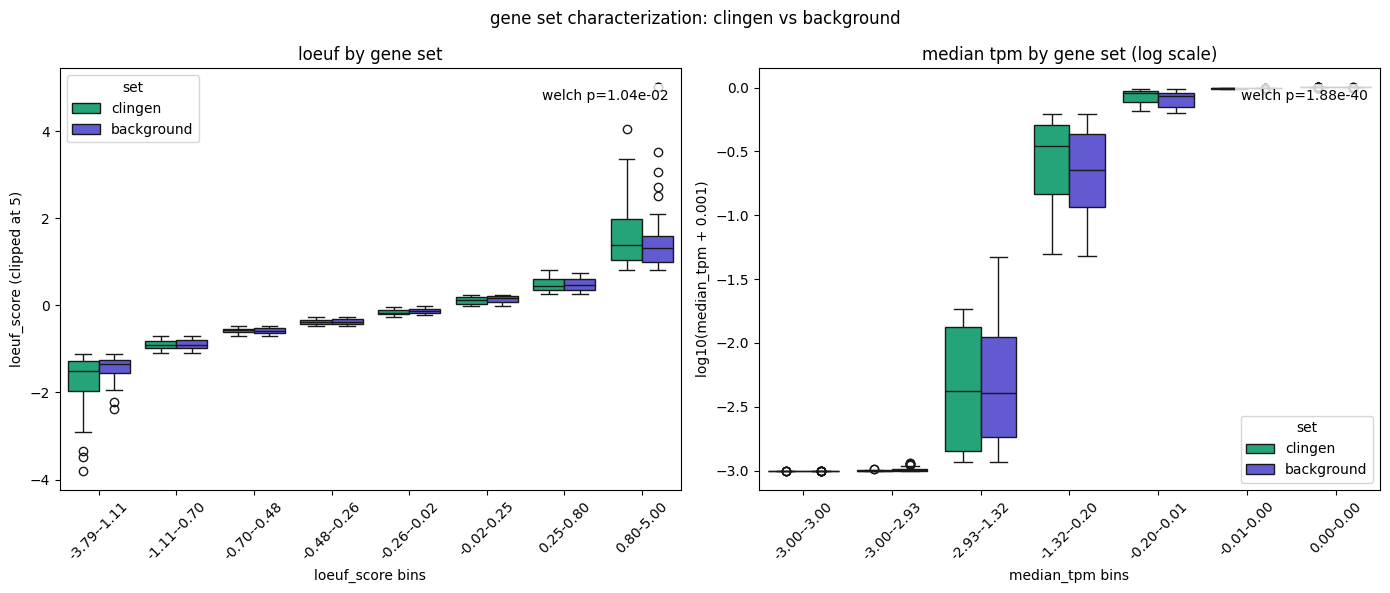

In [10]:
EXPRESSION_CANDIDATES = ['median_tpm', 'tpm']
LOEUF_UPPER = 5.0
TPM_PSEUDOCOUNT = 1e-3


def _load_gene_level_frames() -> dict[str, pl.DataFrame]:
    """load gene-level data for clingen and background.

    returns:
        dict[str, pl.DataFrame]: gene-level tables keyed by set.
    """
    frames: dict[str, pl.DataFrame] = {}
    for set_name, path in {'clingen': CLINGEN_GENE, 'background': BG_GENE}.items():
        frame = pl.read_csv(path) if path.suffix == '.csv' else pl.read_parquet(path)
        frames[set_name] = frame
    return frames


def _select_expression_column(frame: pl.DataFrame) -> str:
    """choose available expression column, preferring median_tpm."""
    for candidate in EXPRESSION_CANDIDATES:
        if candidate in frame.columns:
            return candidate
    raise ValueError('missing expression column (median_tpm or tpm)')


def _prepare_gene_metrics(frames: dict[str, pl.DataFrame]) -> pl.DataFrame:
    """select common fields needed for plotting.

    args:
        frames (dict[str, pl.DataFrame]): raw gene tables keyed by set.

    returns:
        pl.DataFrame: combined table with shared metrics and set labels.

    raises:
        ValueError: when required columns are missing.
    """
    prepared = []
    for set_name, frame in frames.items():
        expr_col = _select_expression_column(frame)
        required = ['gene_id', 'loeuf_score', expr_col]
        missing = [col for col in required if col not in frame.columns]
        if missing:
            raise ValueError(f'missing {missing} for set {set_name}')

        subset = (
            frame.select(required)
            .with_columns(
                pl.lit(set_name).alias('set'),
                pl.col('gene_id').alias('gene'),
                pl.col(expr_col).cast(pl.Float64).alias('median_tpm'),
                pl.col('loeuf_score').cast(pl.Float64),
            )
            .select(['set', 'gene', 'median_tpm', 'loeuf_score'])
        )
        prepared.append(subset)

    return pl.concat(prepared, how='diagonal_relaxed')


def _welch_p_value(df: pd.DataFrame, metric: str) -> float:
    """compute welch's t-test between clingen and background.

    args:
        df (pd.DataFrame): tidy gene metrics with set labels.
        metric (str): column to test.

    returns:
        float: welch's t-test p-value.

    raises:
        ValueError: when data is missing for a set.
    """
    clingen_vals = df.loc[df['set'] == 'clingen', metric].dropna()
    background_vals = df.loc[df['set'] == 'background', metric].dropna()

    if clingen_vals.empty or background_vals.empty:
        raise ValueError(f'no data for {metric}')

    _, p_value = stats.ttest_ind(clingen_vals, background_vals, equal_var=False)
    return float(p_value)


def plot_gene_set_characterization(
    df: pl.DataFrame,
    metric: str,
    ax: plt.Axes,
    clip_upper: float | None = None,
    transform: Callable[[pd.Series], pd.Series] | None = None,
    ylabel: str | None = None,
) -> float:
    """plot binned boxplots for a metric and annotate welch p-value.

    args:
        df (pl.DataFrame): combined gene metrics table.
        metric (str): column to plot and test.
        ax (plt.Axes): target axes.
        clip_upper (float | None): optional upper bound for plotting.
        transform (Callable[[pd.Series], pd.Series] | None): optional axis transform.
        ylabel (str | None): optional y-axis label.

    returns:
        float: welch's t-test p-value.
    """
    plot_df = df.to_pandas()
    plot_df = plot_df.dropna(subset=[metric])
    if plot_df.empty:
        raise ValueError(f'no data for {metric}')

    values = plot_df[metric].copy()
    if clip_upper is not None:
        values = values.clip(upper=clip_upper)
    if transform is not None:
        values = transform(values)
    plot_df['metric_plot'] = values

    plot_df['bin'] = pd.qcut(plot_df['metric_plot'], q=8, duplicates='drop')
    plot_df['bin_label'] = plot_df['bin'].apply(
        lambda interval: f'{interval.left:.2f}-{interval.right:.2f}'
    )

    sns.boxplot(
        data=plot_df,
        x='bin_label',
        y='metric_plot',
        hue='set',
        palette=SOURCE_PALETTE,
        ax=ax,
    )

    ax.set_xlabel(f'{metric} bins')
    ax.set_ylabel(ylabel or metric)
    ax.tick_params(axis='x', rotation=45)

    p_value = _welch_p_value(plot_df, metric)
    ax.text(
        0.98,
        0.95,
        f'welch p={p_value:.2e}',
        transform=ax.transAxes,
        ha='right',
        va='top',
        fontsize=10,
        bbox={'facecolor': 'white', 'alpha': 0.8, 'edgecolor': 'none'},
    )

    return p_value


gene_frames = _load_gene_level_frames()
gene_metrics = _prepare_gene_metrics(gene_frames)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

p_loeuf = plot_gene_set_characterization(
    gene_metrics,
    'loeuf_score',
    axes[0],
    clip_upper=LOEUF_UPPER,
    ylabel='loeuf_score (clipped at 5)',
)

p_tpm = plot_gene_set_characterization(
    gene_metrics,
    'median_tpm',
    axes[1],
    transform=lambda s: np.log10(s + TPM_PSEUDOCOUNT),
    ylabel=f'log10(median_tpm + {TPM_PSEUDOCOUNT})',
)

axes[0].set_title('loeuf by gene set')
axes[1].set_title('median tpm by gene set (log scale)')
fig.suptitle('gene set characterization: clingen vs background')
fig.tight_layout()

print(f'loeuf welch p-value: {p_loeuf:.2e}')
print(f'median tpm welch p-value: {p_tpm:.2e}')

## correlation panels


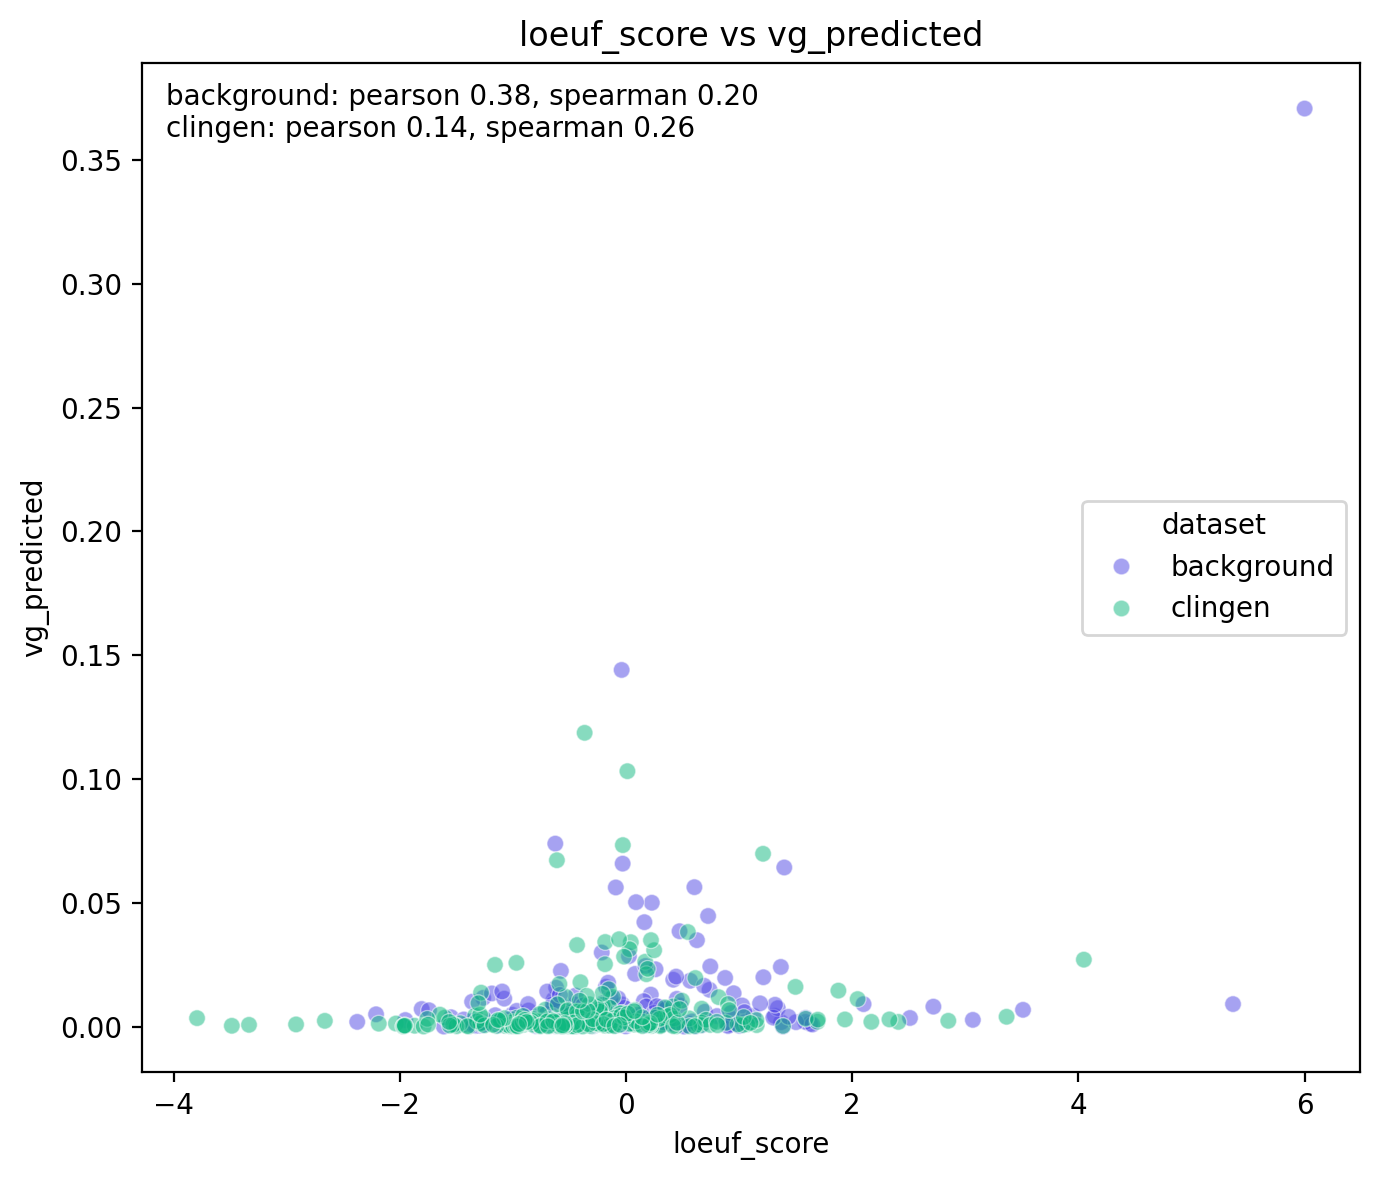

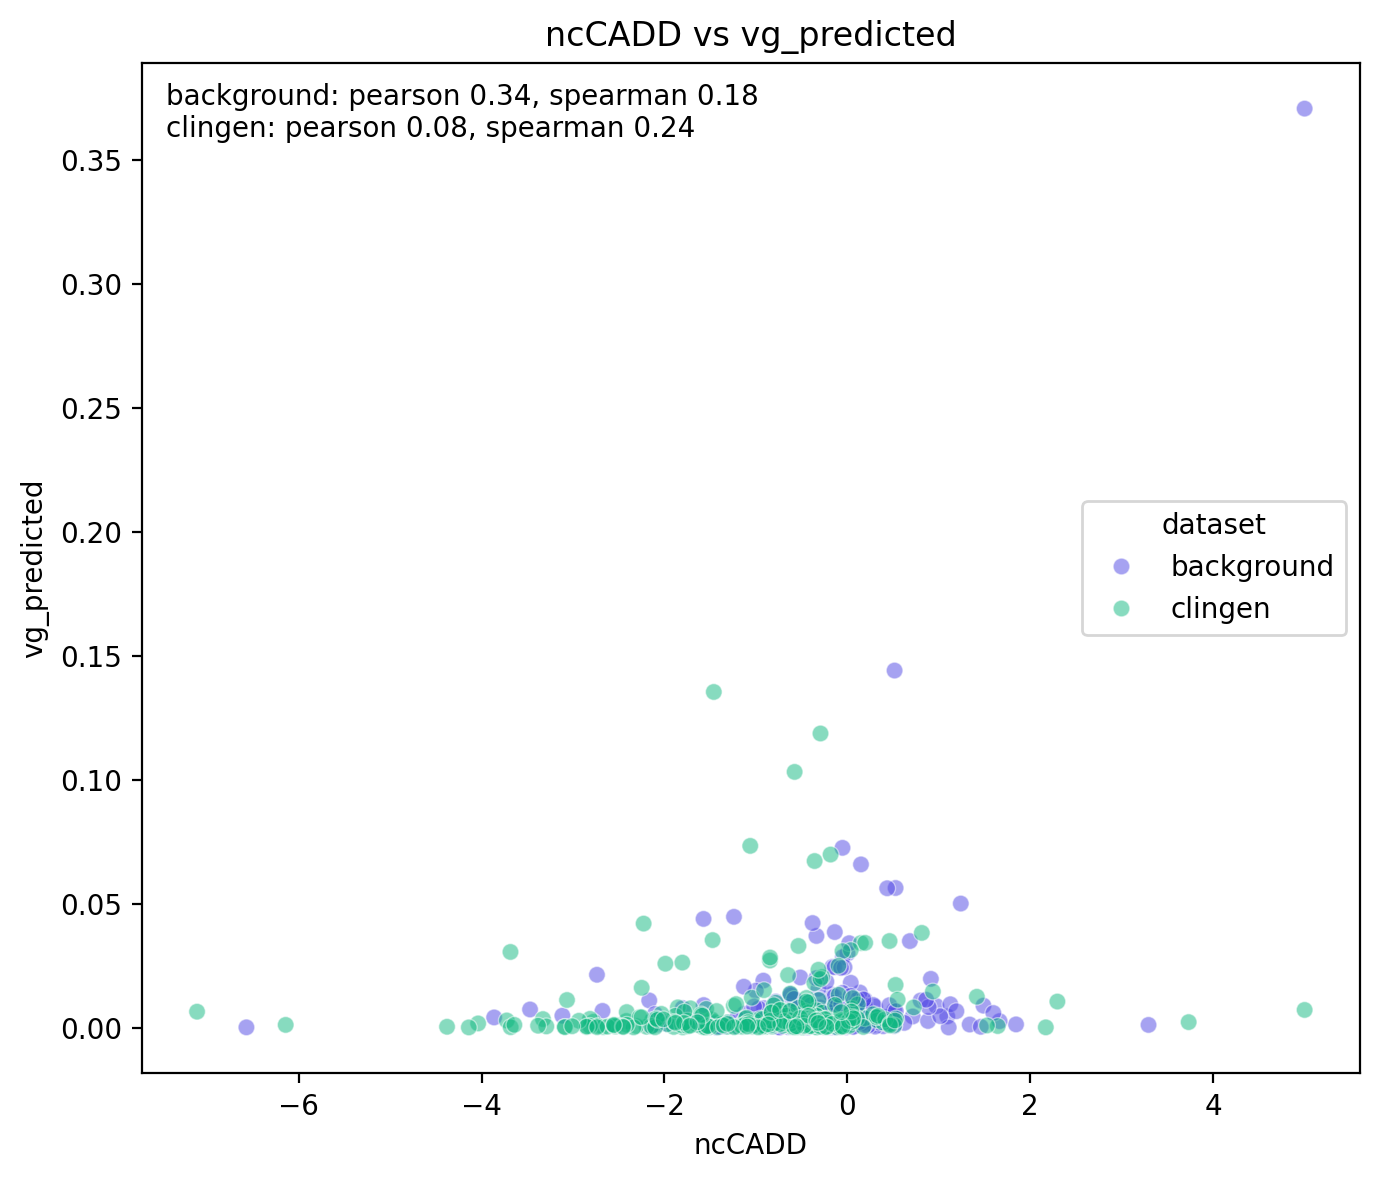

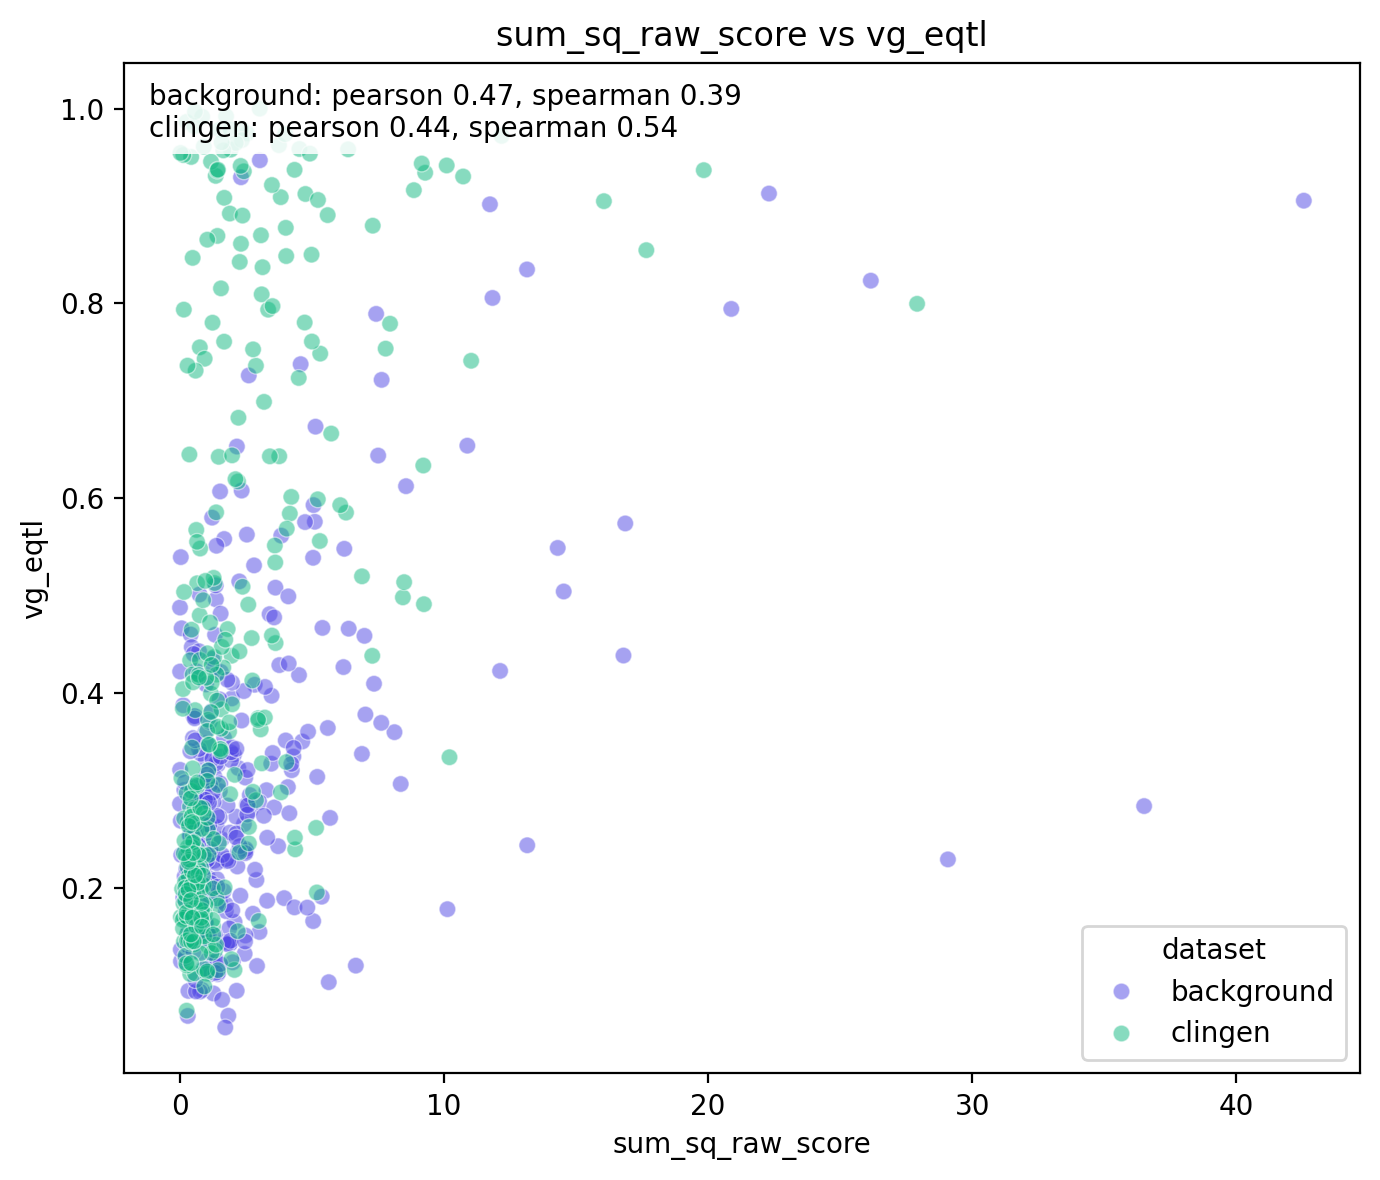

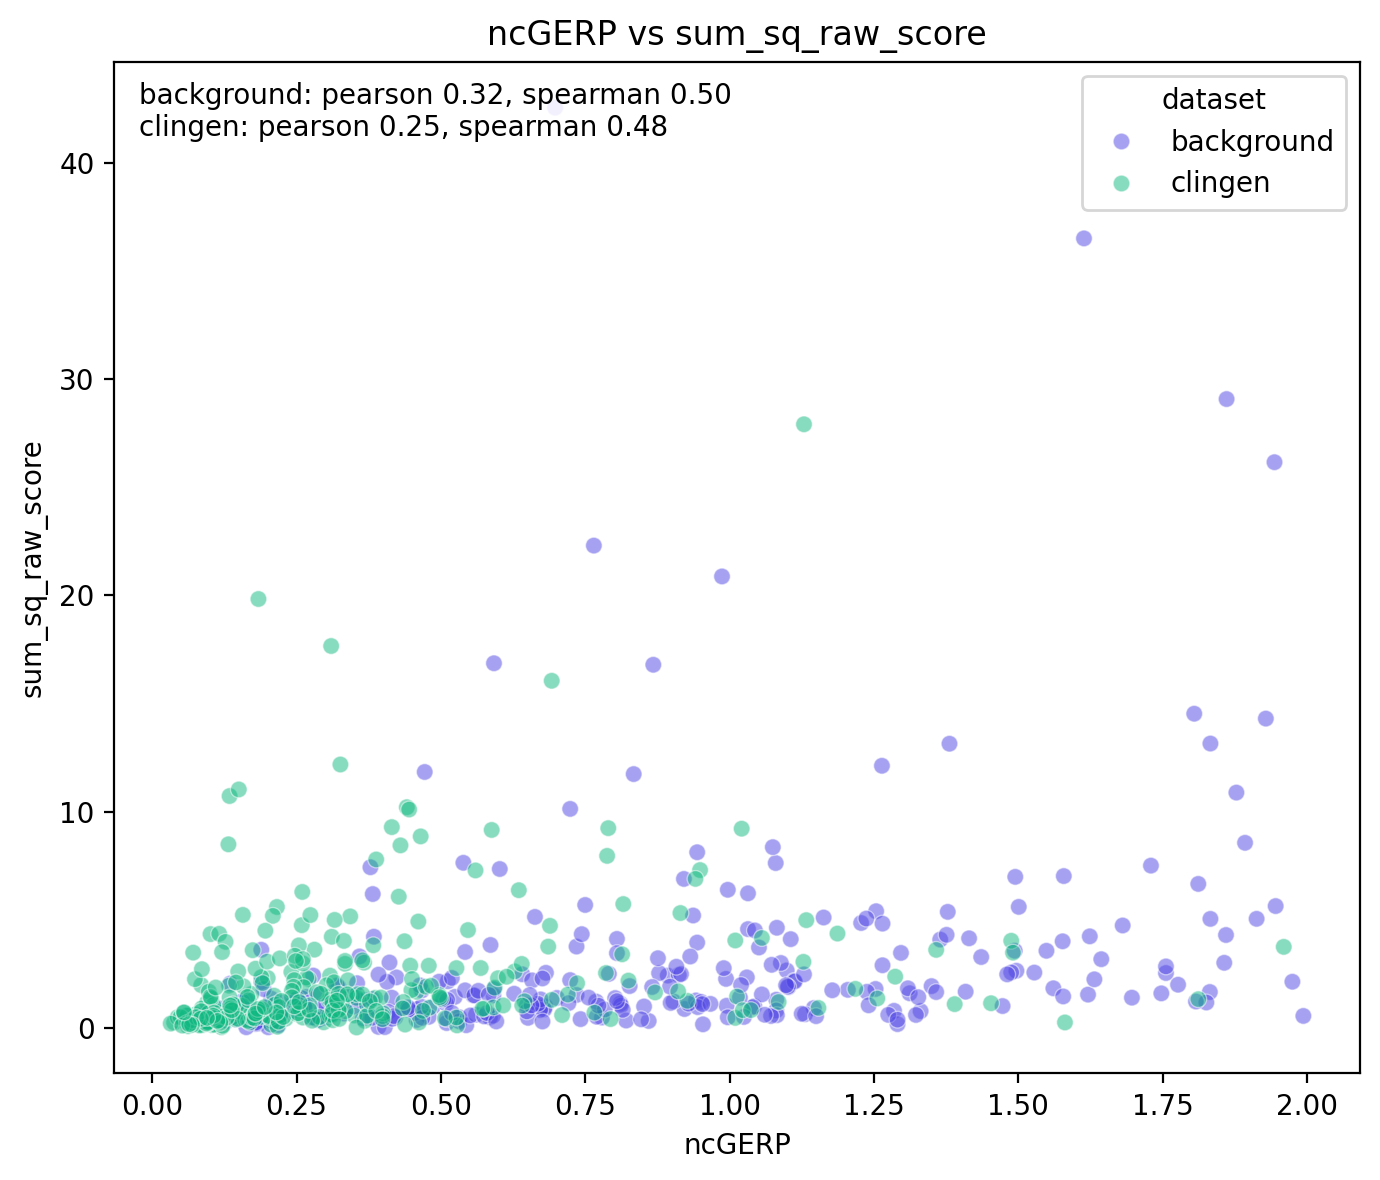

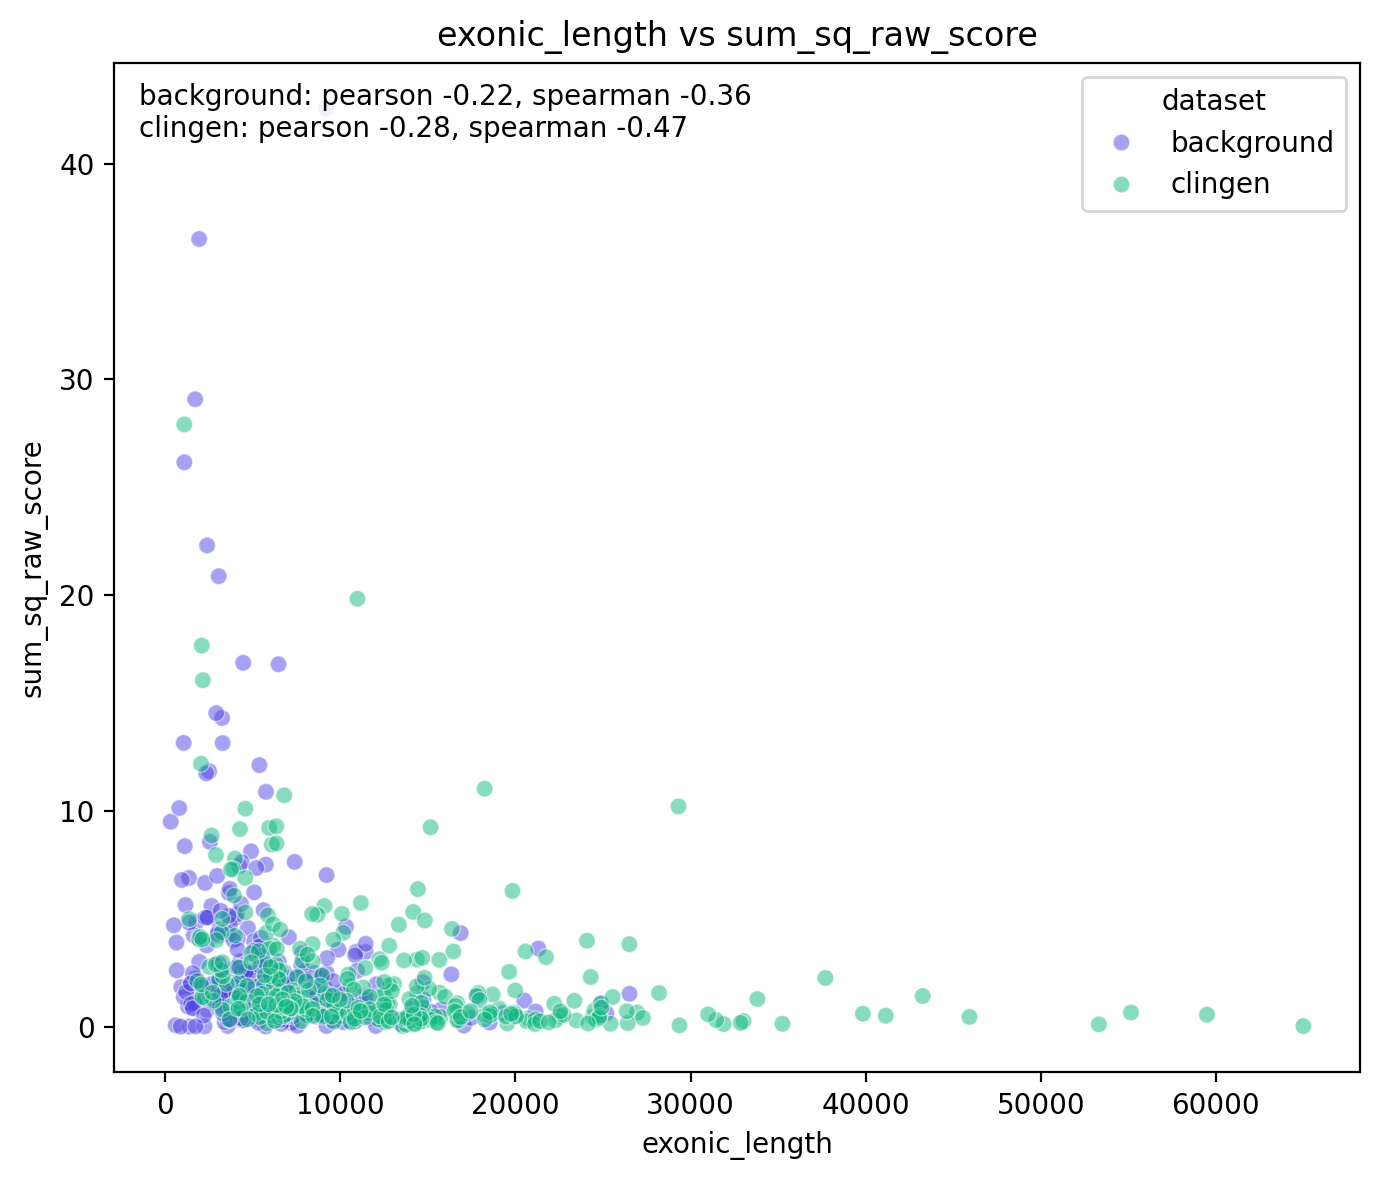

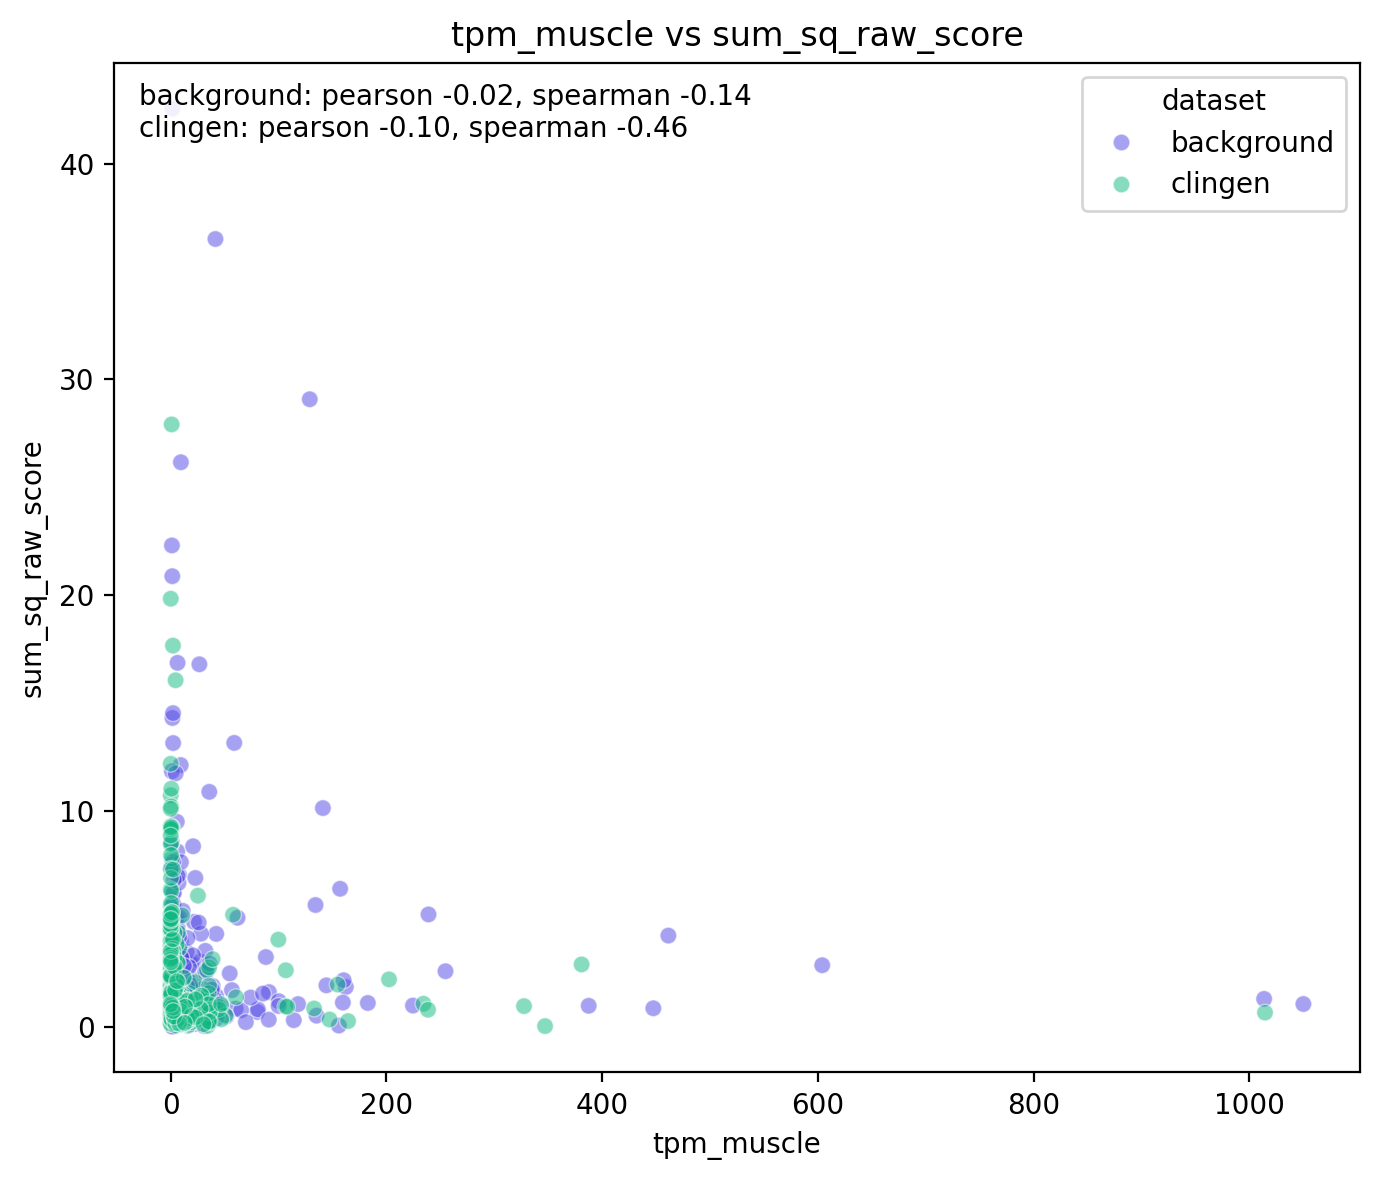

In [11]:
def _load_corr_scatter_frame(columns: list[str]) -> pd.DataFrame:
    """load requested columns plus dataset label for clingen/background."""
    needed = ['gene_id'] + columns
    frames = []
    clip_upper = {
        'loeuf_score': 6,
        'ncCADD': 5,
        'exonic_length': 65000,
        'tpm_muscle': 1050,
    }
    for name, path in [('background', BG_GENE), ('clingen', CLINGEN_GENE)]:
        schema_cols = set(pl.read_parquet(path, n_rows=0).columns)
        missing = [col for col in needed if col not in schema_cols]
        if missing:
            raise ValueError(f'missing {missing} in {name} gene file')
        frame = pl.read_parquet(path).select(needed).with_columns(pl.lit(name).alias('dataset'))
        for col, upper in clip_upper.items():
            if col in frame.columns:
                frame = frame.with_columns(pl.col(col).clip(upper_bound=upper))
        frames.append(frame)
    return pl.concat(frames, how='vertical').to_pandas()


def _annotate_correlations(ax: plt.Axes, df: pd.DataFrame, x: str, y: str) -> None:
    """place pearson and spearman correlations per dataset on axes."""
    lines = []
    for dataset in ['background', 'clingen']:
        subset = df[df['dataset'] == dataset][[x, y]].dropna()
        if subset.empty:
            lines.append(f'{dataset}: no data')
            continue
        pearson = subset.corr(method='pearson').iloc[0, 1]
        spearman = subset.corr(method='spearman').iloc[0, 1]
        lines.append(f"{dataset}: pearson {pearson:.2f}, spearman {spearman:.2f}")
    ax.text(
        0.02,
        0.98,
        '\n'.join(lines),
        transform=ax.transAxes,
        ha='left',
        va='top',
        fontsize=10,
        bbox={'facecolor': 'white', 'alpha': 0.85, 'edgecolor': 'none'},
    )


def _plot_pair(title: str, x: str, y: str, methods: tuple[str, ...] = ('pearson',)) -> None:
    """scatter clingen vs background with correlation annotations."""
    df = _load_corr_scatter_frame([x, y]).dropna(subset=[x, y])
    if df.empty:
        raise ValueError(f'no data for {x} and {y}')

    plt.figure(figsize=(7, 6), dpi=200)
    sns.scatterplot(data=df, x=x, y=y, hue='dataset', palette=SOURCE_PALETTE, alpha=0.5)
    _annotate_correlations(plt.gca(), df, x, y)
    plt.title(title)
    plt.tight_layout()
    plt.show()


# 1. Pearson ClinGen vs Background LOEUF_score and vg_predicted
_plot_pair('loeuf_score vs vg_predicted', 'loeuf_score', 'vg_predicted')

# 2. Pearson ClinGen vs Background ncCADD and vg_predicted
_plot_pair('ncCADD vs vg_predicted', 'ncCADD', 'vg_predicted')

# 3. Pearson + Spearman ClinGen vs Background sum_sq_raw_score and vg_eqtl
_plot_pair(
    'sum_sq_raw_score vs vg_eqtl',
    'sum_sq_raw_score',
    'vg_eqtl',
    methods=('pearson', 'spearman'),
)

# 4. Spearman ClinGen vs Background ncGERP and sum_sq_raw_score
_plot_pair('ncGERP vs sum_sq_raw_score', 'ncGERP', 'sum_sq_raw_score')

# 5. Spearman ClinGen vs Background exonic_length and sum_sq_raw_score
_plot_pair('exonic_length vs sum_sq_raw_score', 'exonic_length', 'sum_sq_raw_score')

# 6. Spearman ClinGen vs Background tpm_muscle and sum_sq_raw_score
_plot_pair('tpm_muscle vs sum_sq_raw_score', 'tpm_muscle', 'sum_sq_raw_score')



## dataset score distributions


/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_99740/843468055.py:58: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/var/folders/4k/lmr1c7ss61n50vqkw_40j0pm0000gn/T/ipykernel_99740/843468055.py:74: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




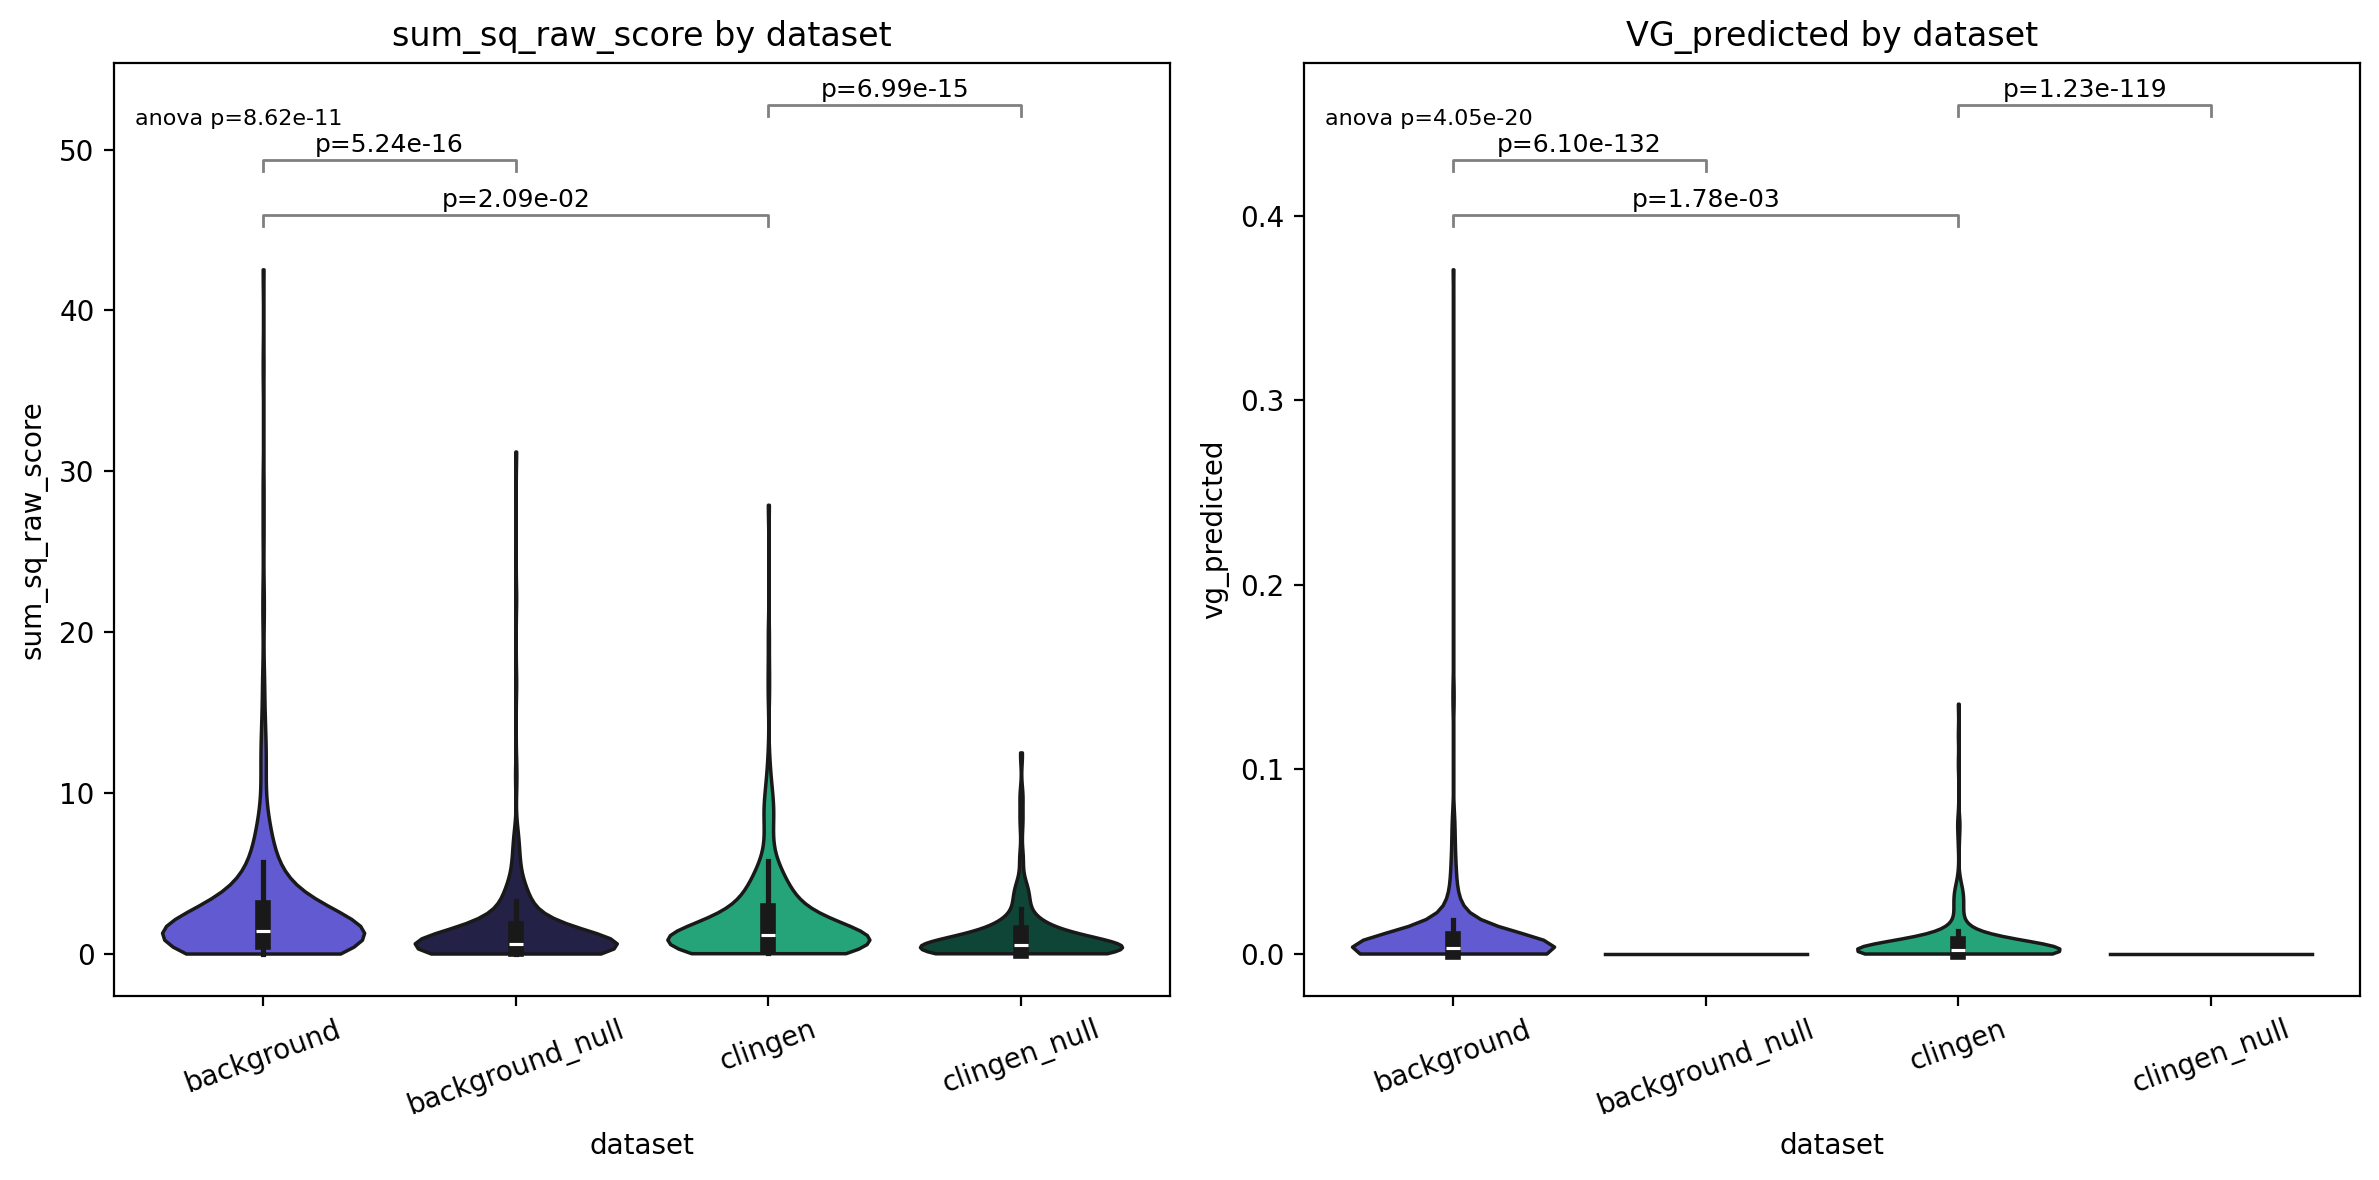

In [12]:
def _load_score_distributions() -> pd.DataFrame:
    """collect sum_sq_raw_score and vg_predicted for all four gene sets."""
    metrics = ['sum_sq_raw_score', 'vg_predicted']
    frames = []
    for name, path in {
        'background': BG_GENE,
        'clingen': CLINGEN_GENE,
        'background_null': BG_NULL_GENE,
        'clingen_null': CLINGEN_NULL_GENE,
    }.items():
        cols = [col for col in metrics if col in pl.read_parquet(path, n_rows=0).columns]
        frame = pl.read_parquet(path).select(cols).with_columns(pl.lit(name).alias('dataset'))
        frames.append(frame)
    return pl.concat(frames, how='vertical').to_pandas()


def plot_score_distributions() -> None:
    df = _load_score_distributions().dropna(subset=['sum_sq_raw_score', 'vg_predicted'])
    if df.empty:
        raise ValueError('no scores available to plot')

    palette = {k: SOURCE_PALETTE[k] for k in df['dataset'].unique() if k in SOURCE_PALETTE}
    order = ['background', 'background_null', 'clingen', 'clingen_null']
    comparisons = [
        ('background', 'clingen'),
        ('background', 'background_null'),
        ('clingen', 'clingen_null'),
    ]

    def _anova_p(metric: str) -> float:
        groups = [group[metric].dropna() for _, group in df.groupby('dataset')]
        if any(g.empty for g in groups):
            return float('nan')
        _, p_val = stats.f_oneway(*groups)
        return float(p_val)

    def _pairwise_p(metric: str, a: str, b: str) -> float:
        vals_a = df.loc[df['dataset'] == a, metric].dropna()
        vals_b = df.loc[df['dataset'] == b, metric].dropna()
        if vals_a.empty or vals_b.empty:
            return float('nan')
        _, p_val = stats.mannwhitneyu(vals_a, vals_b, alternative='two-sided')
        return float(p_val)

    def _annotate_pairs(ax: plt.Axes, metric: str) -> None:
        y_max = df[metric].max()
        step = (df[metric].max() - df[metric].min()) * 0.08 if df[metric].max() > df[metric].min() else 1.0
        for i, (a, b) in enumerate(comparisons):
            pa = order.index(a)
            pb = order.index(b)
            x1, x2 = min(pa, pb), max(pa, pb)
            y = y_max + step * (i + 1)
            p_val = _pairwise_p(metric, a, b)
            ax.plot([x1, x1, x2, x2], [y - step * 0.2, y, y, y - step * 0.2], color='gray', linewidth=1)
            ax.text((x1 + x2) / 2, y + step * 0.05, f'p={p_val:.2e}', ha='center', va='bottom', fontsize=9)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi=200)
    sns.violinplot(data=df, x='dataset', y='sum_sq_raw_score', palette=palette, cut=0, order=order, ax=axes[0])
    p_sum = _anova_p('sum_sq_raw_score')
    axes[0].text(
        0.02,
        0.95,
        f'anova p={p_sum:.2e}',
        transform=axes[0].transAxes,
        ha='left',
        va='top',
        fontsize=8,
        bbox={'facecolor': 'white', 'alpha': 0.85, 'edgecolor': 'none'},
    )
    _annotate_pairs(axes[0], 'sum_sq_raw_score')
    axes[0].set_title('sum_sq_raw_score by dataset')
    axes[0].tick_params(axis='x', rotation=20)

    sns.violinplot(data=df, x='dataset', y='vg_predicted', palette=palette, cut=0, order=order, ax=axes[1])
    p_vg = _anova_p('vg_predicted')
    axes[1].text(
        0.02,
        0.95,
        f'anova p={p_vg:.2e}',
        transform=axes[1].transAxes,
        ha='left',
        va='top',
        fontsize=8,
        bbox={'facecolor': 'white', 'alpha': 0.85, 'edgecolor': 'none'},
    )
    _annotate_pairs(axes[1], 'vg_predicted')
    axes[1].set_title('VG_predicted by dataset')
    axes[1].tick_params(axis='x', rotation=20)

    fig.tight_layout()
    plt.show()


plot_score_distributions()



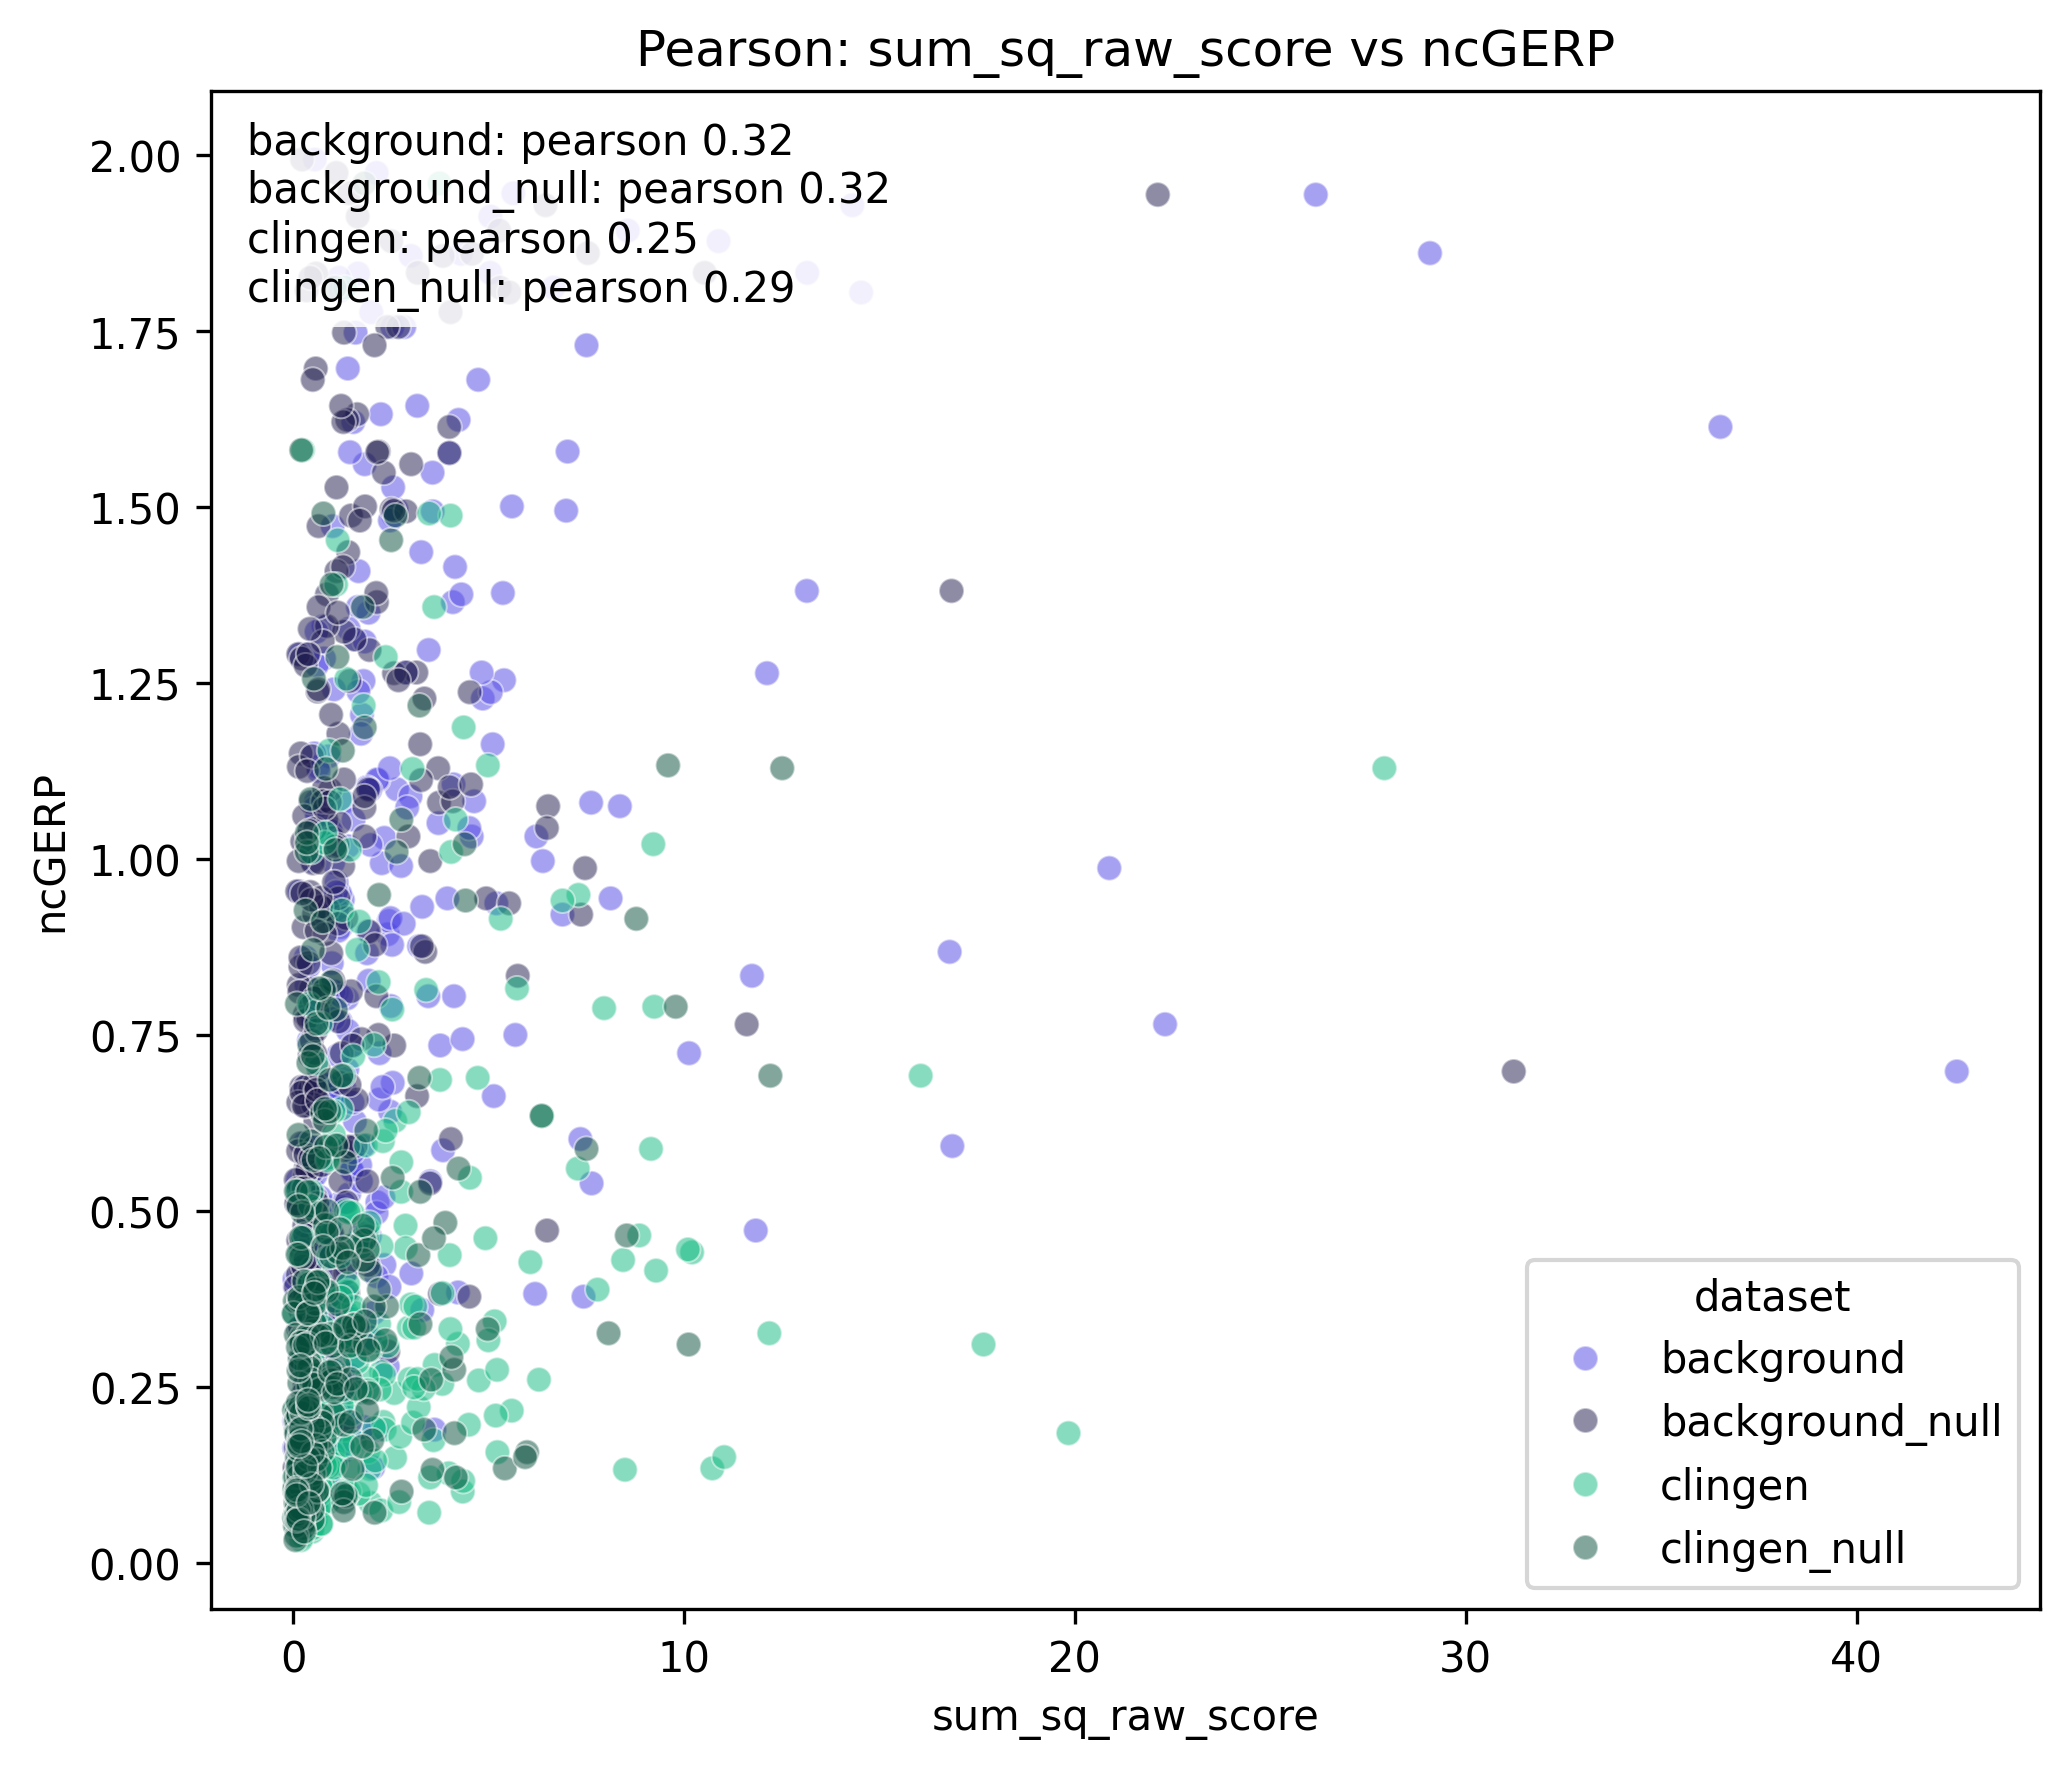

In [13]:
def _load_corr_scatter_frame_all(columns: list[str]) -> pd.DataFrame:
    """load requested columns plus dataset label for all gene sets."""
    needed = ['gene_id'] + columns
    frames = []
    for name, path in [
        ('background', BG_GENE),
        ('background_null', BG_NULL_GENE),
        ('clingen', CLINGEN_GENE),
        ('clingen_null', CLINGEN_NULL_GENE),
    ]:
        schema_cols = set(pl.read_parquet(path, n_rows=0).columns)
        missing = [col for col in needed if col not in schema_cols]
        if missing:
            raise ValueError(f'missing {missing} in {name} gene file')
        frame = pl.read_parquet(path).select(needed).with_columns(pl.lit(name).alias('dataset'))
        frames.append(frame)
    return pl.concat(frames, how='vertical').to_pandas()


def _annotate_correlations_multi(ax: plt.Axes, df: pd.DataFrame, x: str, y: str) -> None:
    """annotate pearson correlations per dataset."""
    lines: list[str] = []
    for dataset in df['dataset'].unique():
        subset = df[df['dataset'] == dataset][[x, y]].dropna()
        if subset.empty:
            lines.append(f'{dataset}: no data')
            continue
        pearson = subset.corr(method='pearson').iloc[0, 1]
        lines.append(f"{dataset}: pearson {pearson:.2f}")
    ax.text(
        0.02,
        0.98,
        '\n'.join(lines),
        transform=ax.transAxes,
        ha='left',
        va='top',
        fontsize=10,
        bbox={'facecolor': 'white', 'alpha': 0.85, 'edgecolor': 'none'},
    )


def plot_pearson_sum_sq_vs_ncgerp_all() -> None:
    """scatter pearson ncGERP vs sum_sq_raw_score for all datasets."""
    df = _load_corr_scatter_frame_all(['sum_sq_raw_score', 'ncGERP']).dropna(subset=['sum_sq_raw_score', 'ncGERP'])
    if df.empty:
        raise ValueError('no data for sum_sq_raw_score and ncGERP')

    palette = {k: SOURCE_PALETTE[k] for k in df['dataset'].unique() if k in SOURCE_PALETTE}

    plt.figure(figsize=(7, 6), dpi=300)
    sns.scatterplot(data=df, x='sum_sq_raw_score', y='ncGERP', hue='dataset', palette=palette, alpha=0.5)
    _annotate_correlations_multi(plt.gca(), df, 'sum_sq_raw_score', 'ncGERP')
    plt.title('Pearson: sum_sq_raw_score vs ncGERP')
    plt.tight_layout()
    plt.show()


plot_pearson_sum_sq_vs_ncgerp_all()



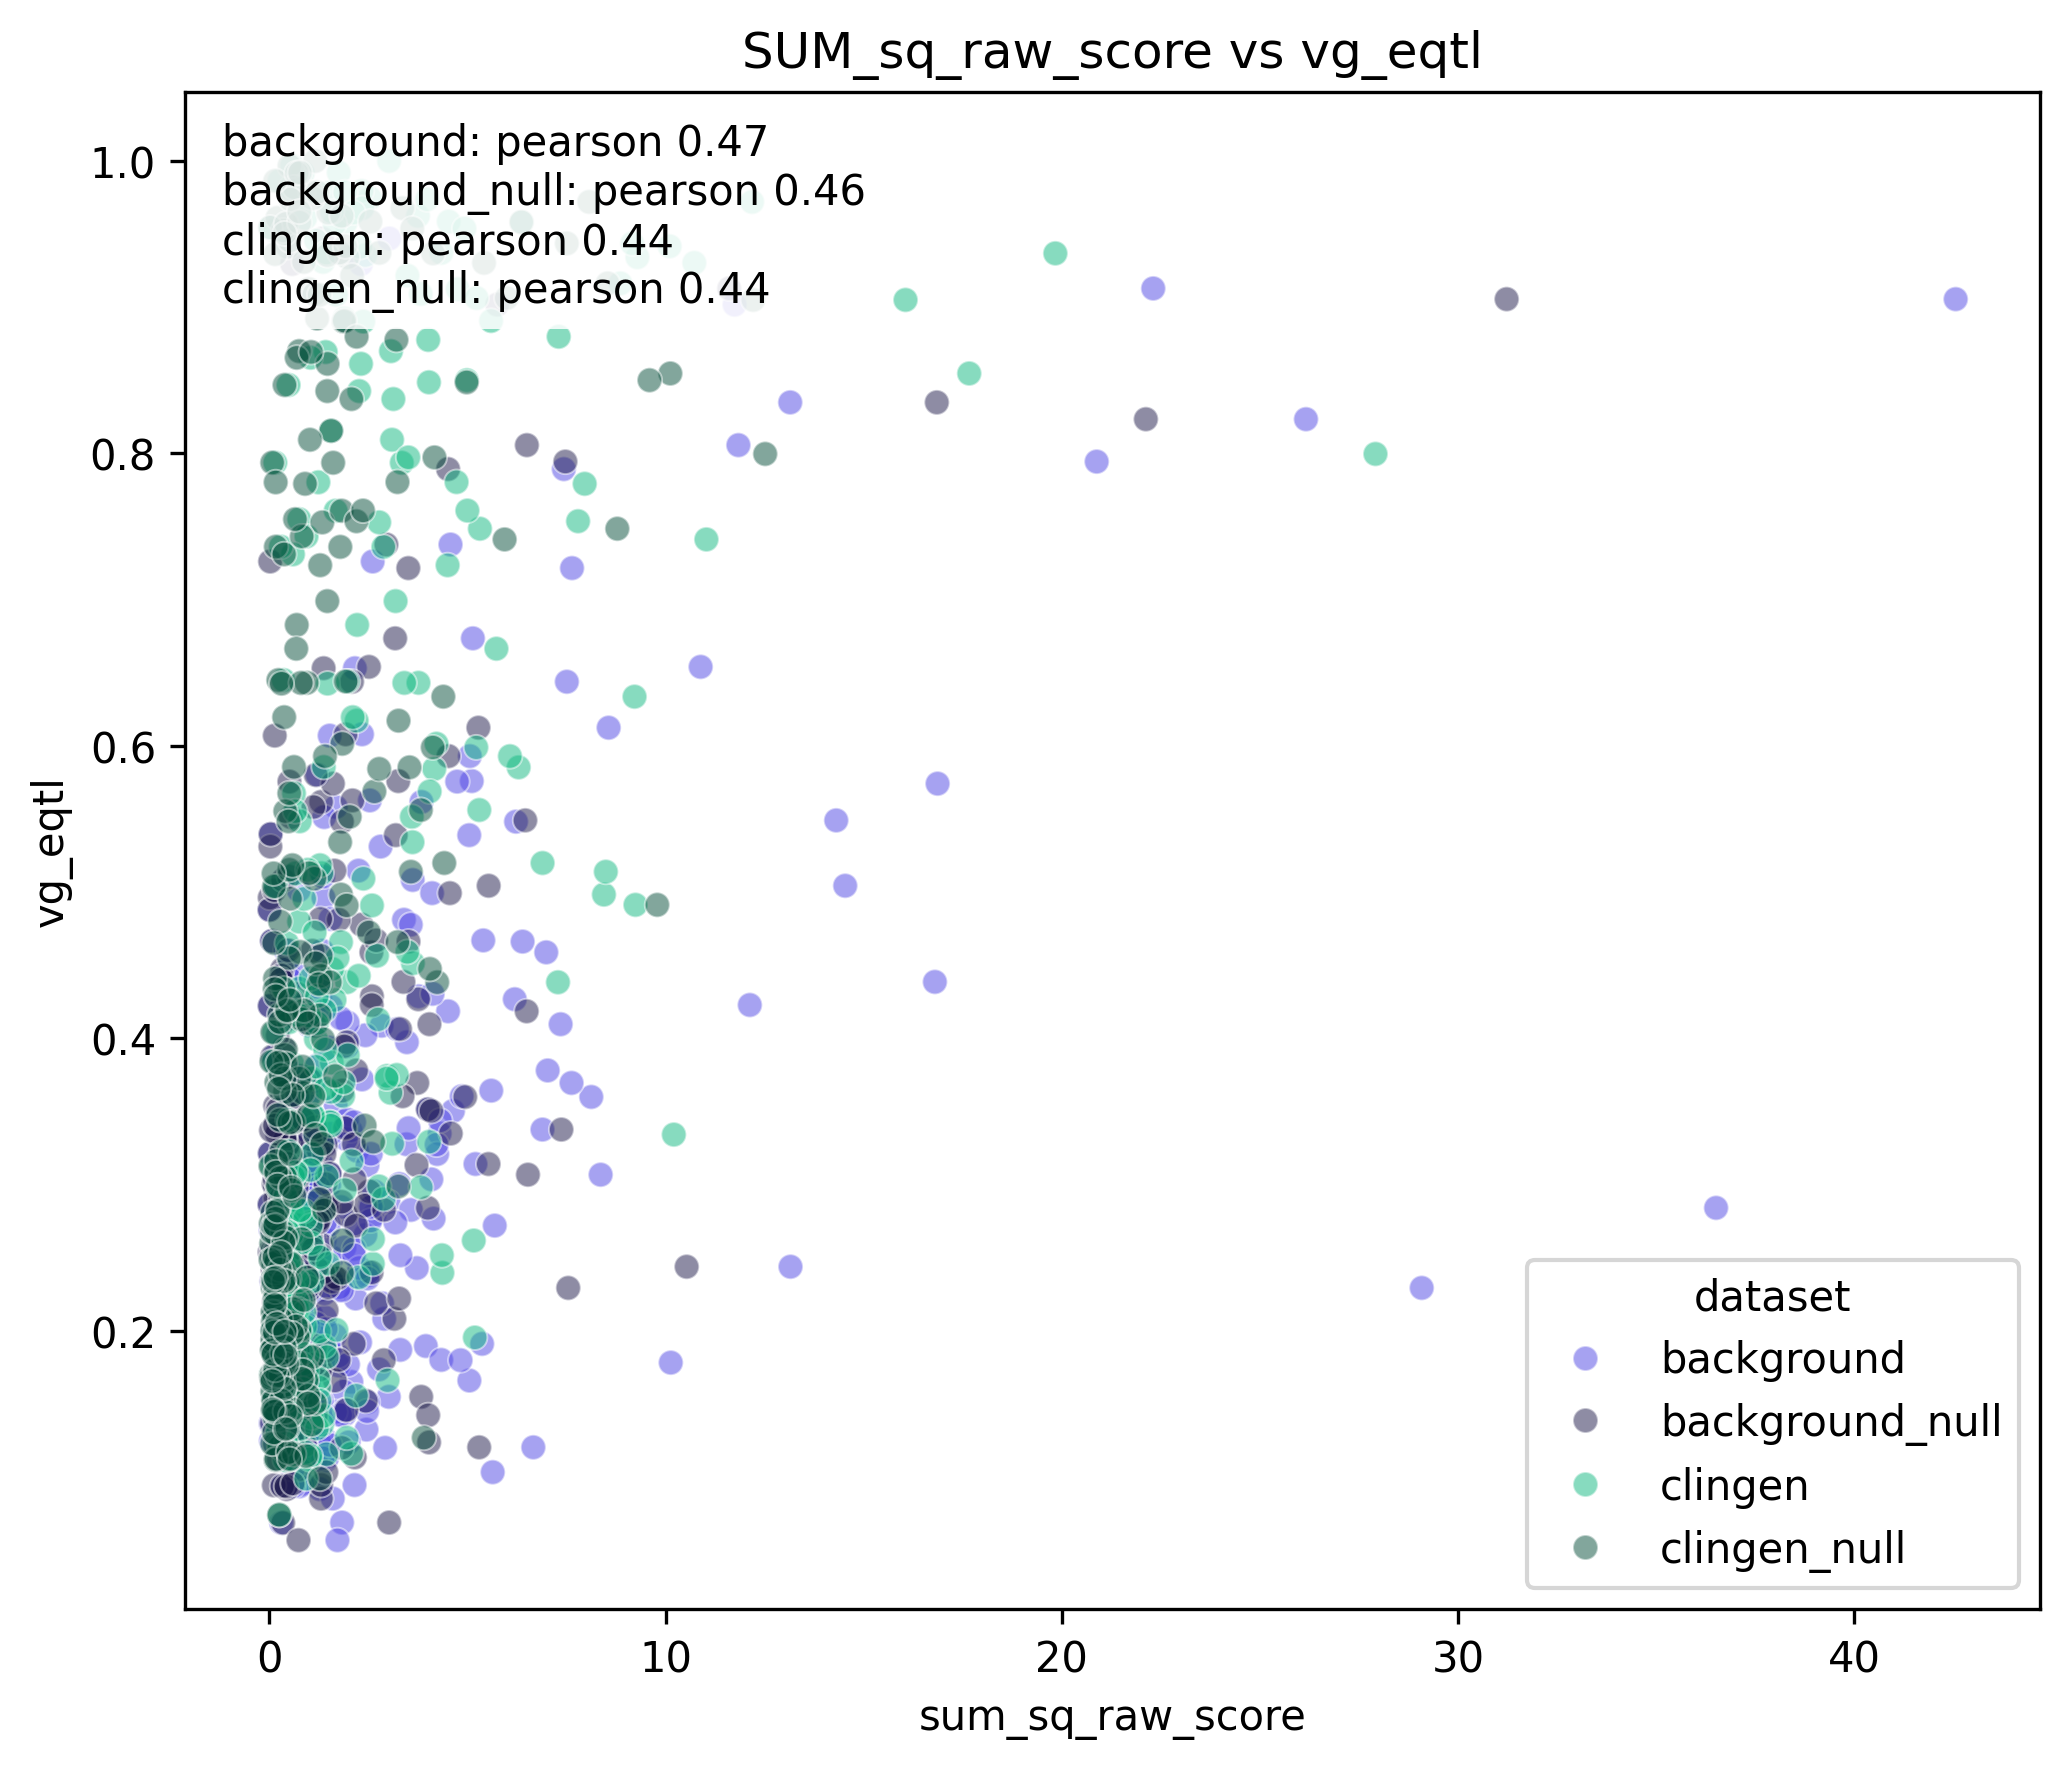

In [14]:
def plot_pearson_sum_sq_vs_vg_eqtl_all() -> None:
    """scatter pearson vg_eqtl vs sum_sq_raw_score for all datasets."""
    df = _load_corr_scatter_frame_all(['sum_sq_raw_score', 'vg_eqtl']).dropna(subset=['sum_sq_raw_score', 'vg_eqtl'])
    if df.empty:
        raise ValueError('no data for sum_sq_raw_score and vg_eqtl')

    palette = {k: SOURCE_PALETTE[k] for k in df['dataset'].unique() if k in SOURCE_PALETTE}

    plt.figure(figsize=(7, 6), dpi=300)
    sns.scatterplot(data=df, x='sum_sq_raw_score', y='vg_eqtl', hue='dataset', palette=palette, alpha=0.5)
    _annotate_correlations_multi(plt.gca(), df, 'sum_sq_raw_score', 'vg_eqtl')
    plt.title('SUM_sq_raw_score vs vg_eqtl')
    plt.tight_layout()
    plt.show()


plot_pearson_sum_sq_vs_vg_eqtl_all()



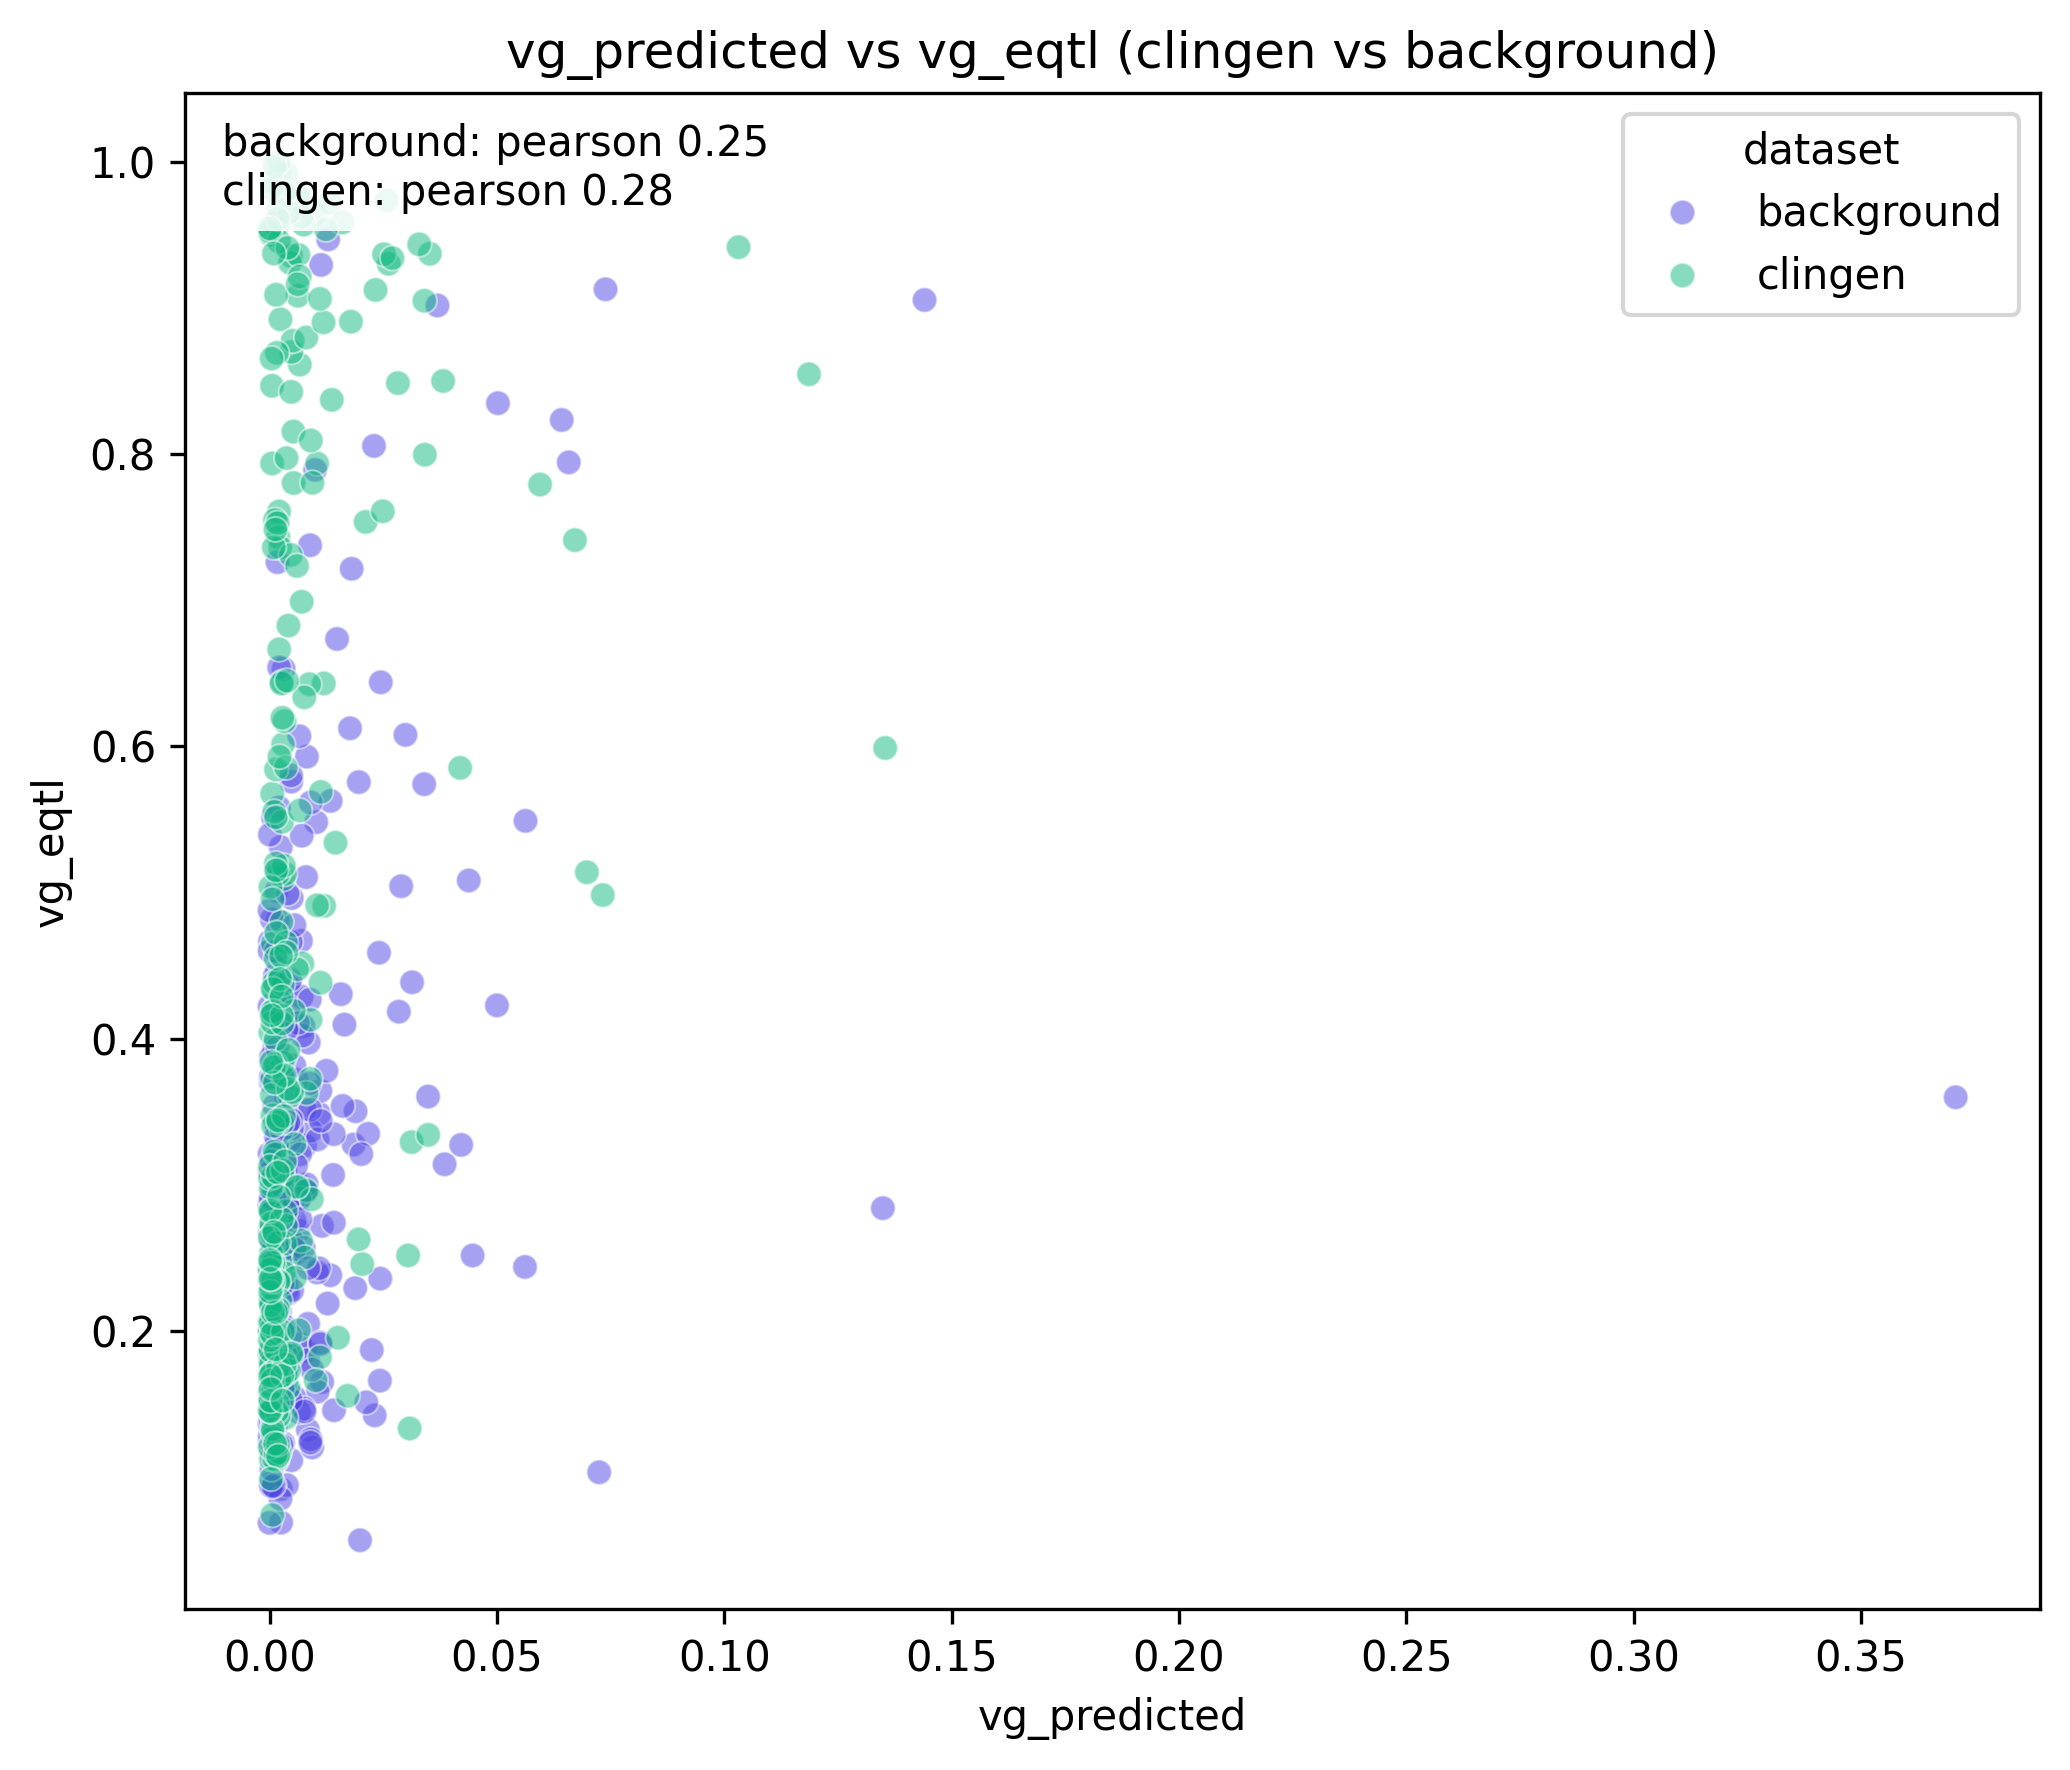

In [15]:
def plot_pearson_sum_sq_vs_vg_eqtl() -> None:
    """scatter pearson vg_eqtl vs vg_predicted for clingen/background."""
    df = _load_corr_scatter_frame(['vg_predicted', 'vg_eqtl']).dropna(subset=['vg_predicted', 'vg_eqtl'])
    if df.empty:
        raise ValueError('no data for vg_predicted and vg_eqtl')

    palette = {k: SOURCE_PALETTE[k] for k in df['dataset'].unique() if k in SOURCE_PALETTE}

    plt.figure(figsize=(7, 6), dpi=300)
    sns.scatterplot(data=df, x='vg_predicted', y='vg_eqtl', hue='dataset', palette=palette, alpha=0.5)
    _annotate_correlations_multi(plt.gca(), df, 'vg_predicted', 'vg_eqtl')
    plt.title('vg_predicted vs vg_eqtl (clingen vs background)')
    plt.tight_layout()
    plt.show()


plot_pearson_sum_sq_vs_vg_eqtl()



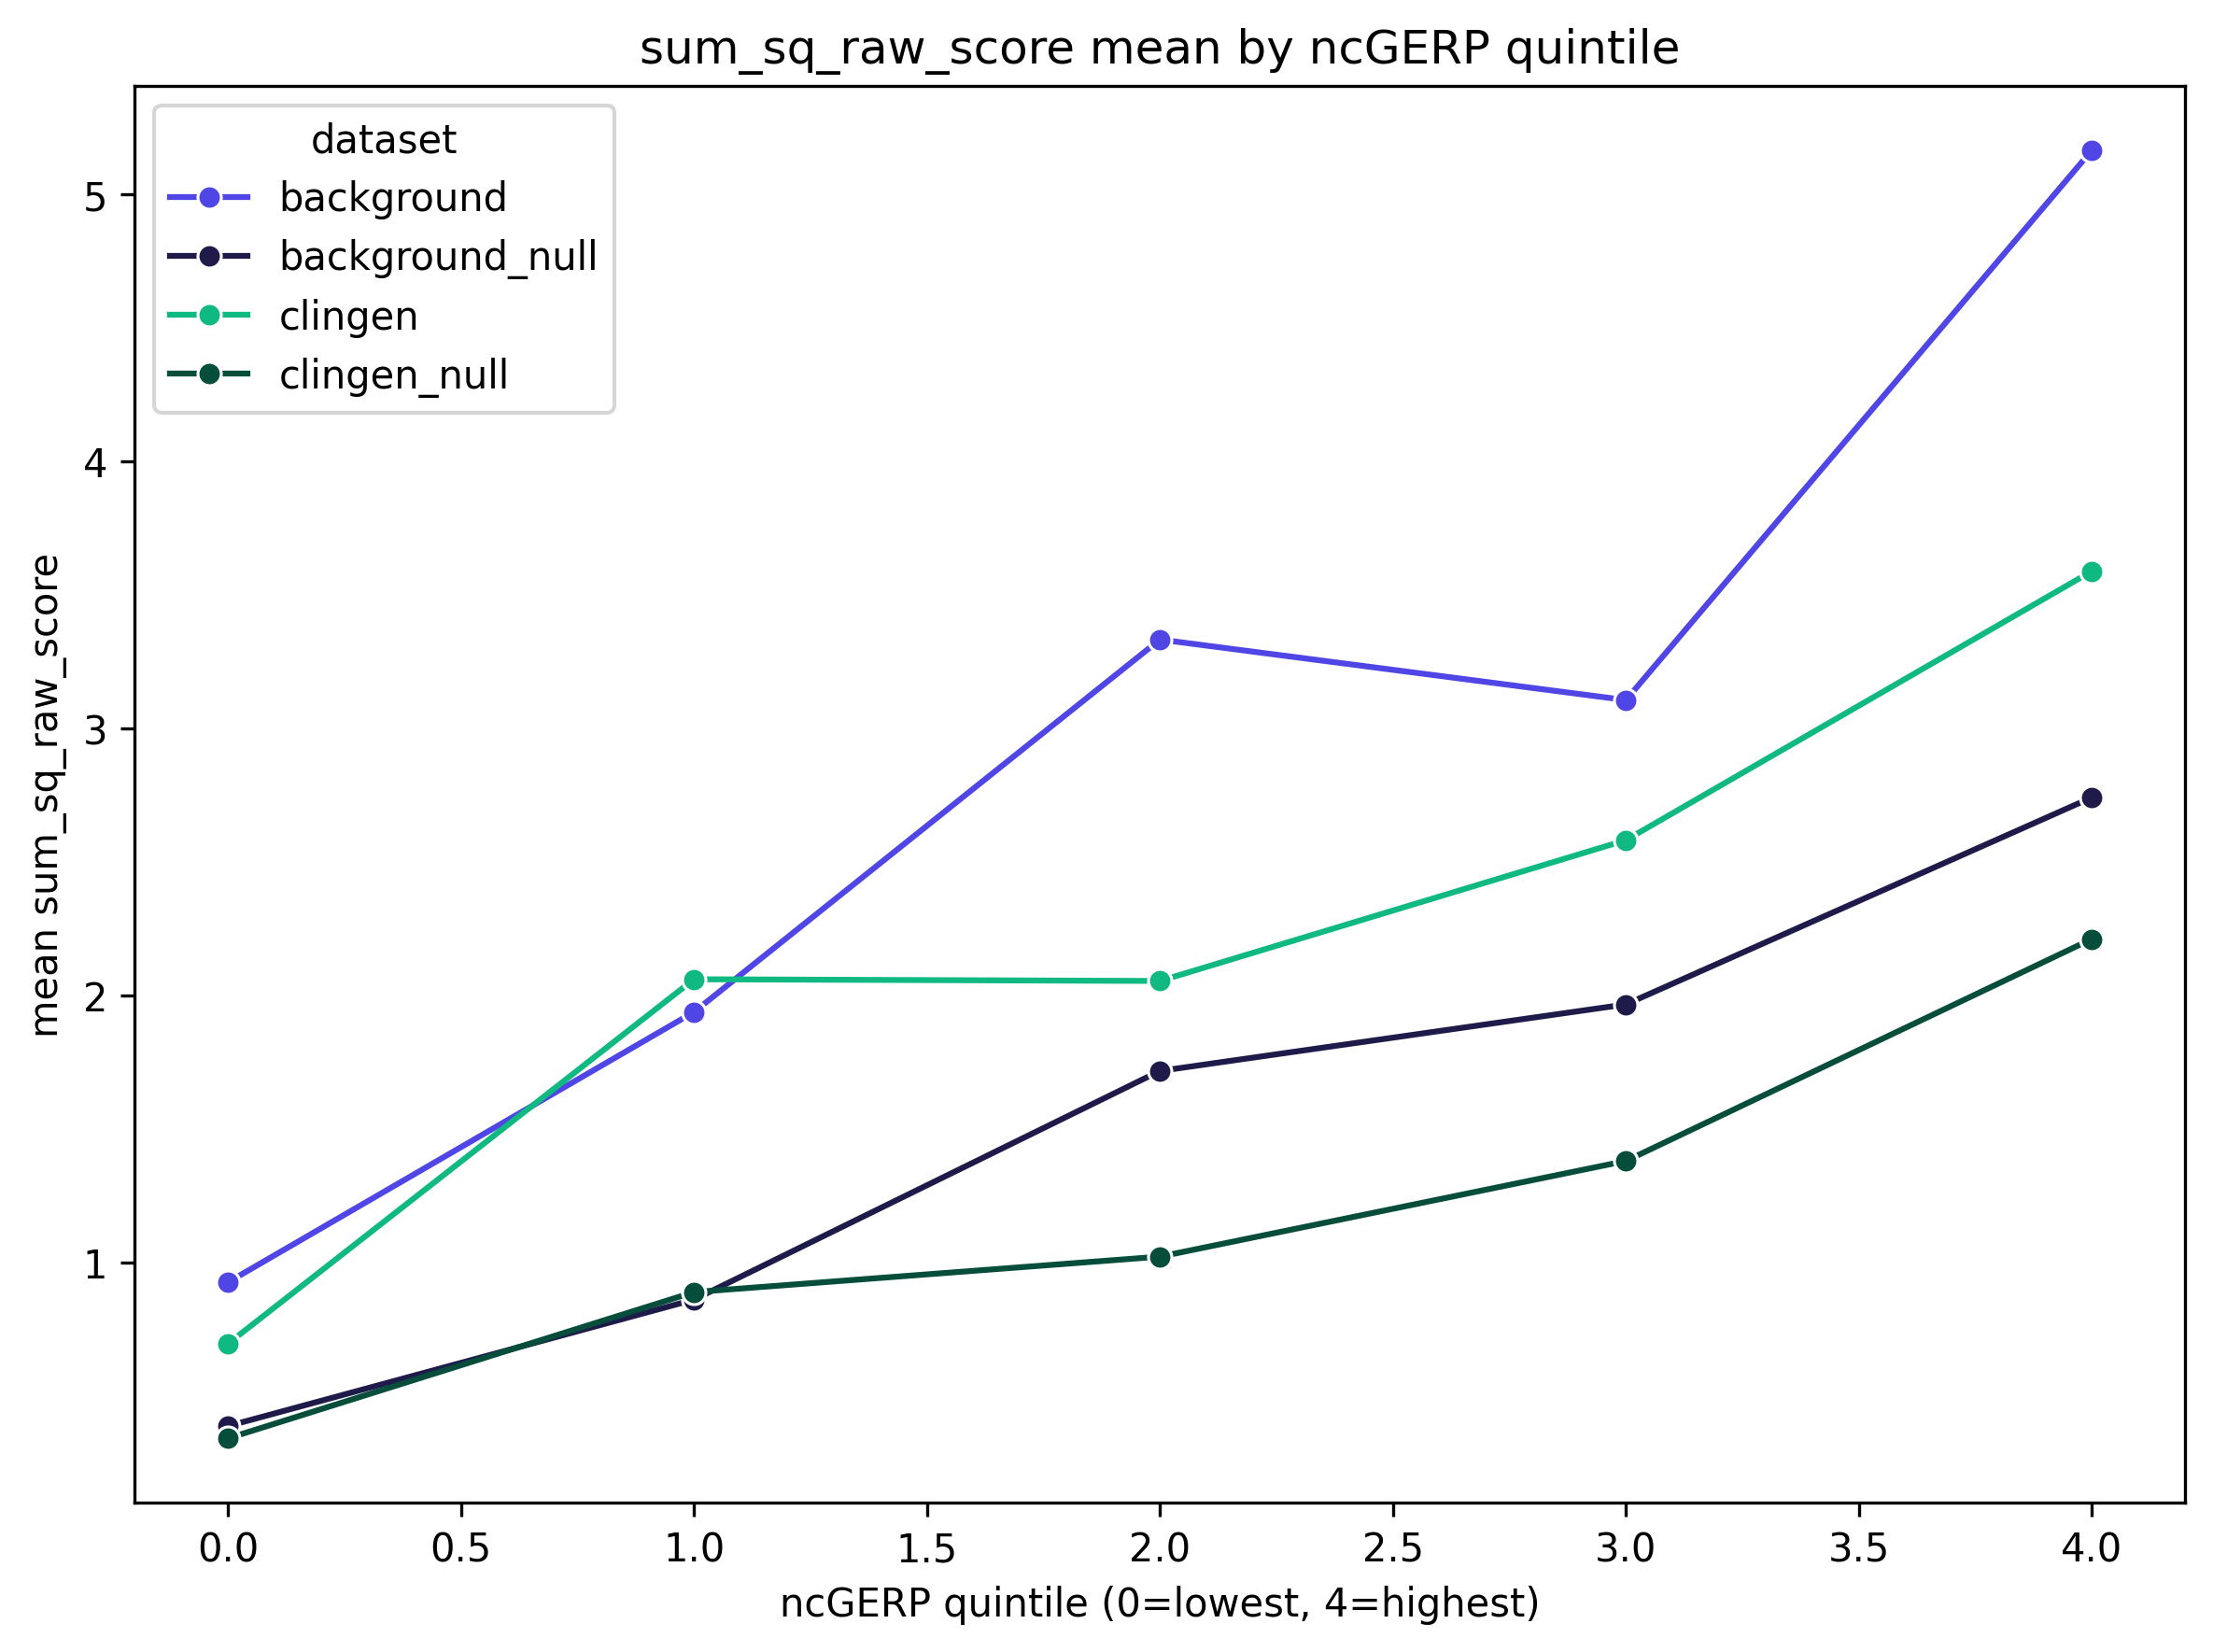

In [16]:
def _load_ncgerp_metric(metric: str) -> pd.DataFrame:
    """load ncGERP and requested metric for all four datasets."""
    frames: list[pd.DataFrame] = []
    for name, path in {
        'background': BG_GENE,
        'background_null': BG_NULL_GENE,
        'clingen': CLINGEN_GENE,
        'clingen_null': CLINGEN_NULL_GENE,
    }.items():
        cols = ['ncGERP', metric]
        schema_cols = set(pl.read_parquet(path, n_rows=0).columns)
        missing = [col for col in cols if col not in schema_cols]
        if missing:
            raise ValueError(f'missing {missing} in {name} gene file')
        frame = pl.read_parquet(path).select(cols).to_pandas()
        frame['dataset'] = name
        frames.append(frame)
    return pd.concat(frames, axis=0, ignore_index=True)


def plot_ncgerp_quintile_means(metric: str = 'sum_sq_raw_score') -> None:
    """plot mean metric by ncGERP quintile for each dataset."""
    df = _load_ncgerp_metric(metric).dropna(subset=['ncGERP', metric])
    if df.empty:
        raise ValueError(f'no data for ncGERP and {metric}')

    df['quintile'] = (
        df.groupby('dataset')['ncGERP']
        .transform(lambda s: pd.qcut(s, q=5, labels=False, duplicates='drop'))
        .astype(int)
    )
    summary = (
        df.groupby(['dataset', 'quintile'])[metric]
        .mean()
        .reset_index()
        .rename(columns={metric: 'mean_metric'})
    )

    plt.figure(figsize=(8, 6), dpi=300)
    sns.lineplot(
        data=summary,
        x='quintile',
        y='mean_metric',
        hue='dataset',
        palette={k: SOURCE_PALETTE.get(k, '#333333') for k in summary['dataset'].unique()},
        marker='o',
    )
    plt.xlabel('ncGERP quintile (0=lowest, 4=highest)')
    plt.ylabel(f'mean {metric}')
    plt.title(f'{metric} mean by ncGERP quintile')
    plt.tight_layout()
    plt.show()


plot_ncgerp_quintile_means('sum_sq_raw_score')

